# Climate Model Analysis and Prediction


## Overview

This Notebook implements a climate prediction model using LSTM (Long Short-Term Memory) neural networks to analyze and forecast various climate parameters in Madhya Pradesh, India. The model incorporates multiple climate indices and creates visualizations for both historical data and future predictions.

## Model Preparation

### 1. Data Loading and Processing

- Imports essential libraries for data analysis, machine learning, and visualization
- Sets up data loading structure for multiple climate parameters:
  - Humidity
  - Land Surface Temperature (LST)
  - Precipitation
  - Rainfall
  - Wind Speed

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.dates as mdates
from keras.losses import MeanSquaredError

# Data Loading and Processing
def load_data():
    """Load data from CSV files and return a dictionary of dataframes."""
    data_paths = {
        'Humidity': {
            'annual': '../data/Humidity/mp_annual_humidity_data.csv',
            'monthly': '../data/Humidity/mp_monthly_humidity_data.csv'
        },
        'LST': {
            'annual': '../data/LST/mp_annual_lst_data.csv',
            'monthly': '../data/LST/mp_monthly_lst_data.csv'
        },
        'Precipitation': {
            'annual': '../data/Precipitation/mp_annual_precipitation_data.csv',
            'monthly': '../data/Precipitation/mp_monthly_precipitation_data.csv',
            'seasonal': '../data/Precipitation/mp_seasonal_precipitation_data.csv'
        },
        'RainFall': {
            'annual': '../data/RainFall/mp_annual_rainfall_data.csv',
            'monthly': '../data/RainFall/mp_monthly_rainfall_data.csv'
        },
        'WindSpeed': {
            'annual': '../data/WindSpeed/mp_annual_wind_data.csv',
            'monthly': '../data/WindSpeed/mp_monthly_wind_data.csv'
        }
    }

    data = {}
    for feature, paths in data_paths.items():
        data[feature] = {
            timeframe: pd.read_csv(path)
            for timeframe, path in paths.items()
        }

    return data

### 2. Climate Indices Calculations
Key indices calculated include:

#### SPEI (Standardized Precipitation-Evapotranspiration Index)
```python
spei = (precip - potential_evapotranspiration) / np.std(precip - potential_evapotranspiration)
```
- Measures drought severity by incorporating both precipitation and evapotranspiration
- Normalized index where negative values indicate drought conditions

#### PDSI (Palmer Drought Severity Index)
```python
water_balance = precip - (0.0023 * temp + 0.37)
z = (water_balance - np.mean(water_balance)) / np.std(water_balance)
pdsi = 0.897 * z + water_balance
```
- Indicates long-term drought conditions
- Considers both precipitation and temperature effects

#### SPI (Standardized Precipitation Index)
```python
spi = (precip - np.mean(precip)) / np.std(precip)
```
- Measures precipitation anomalies
- Useful for monitoring both wet and dry periods

#### THI (Temperature-Humidity Index)
```python
thi = temp - 0.55 * (1 - humidity) * (temp - 14.5)
```
- Measures heat stress combining temperature and humidity effects
- Important for agricultural and livestock applications


In [2]:
# Climate Indices Calculations
def calculate_climate_indices(data):
    """Calculate various climate indices from the data."""

    # Extract monthly data
    monthly_data = {
        feature: data[feature]['monthly']
        for feature in data.keys()
        if 'monthly' in data[feature]
    }

    # Calculate SPEI (Standardized Precipitation-Evapotranspiration Index)
    def calculate_spei(precip, humidity):
        """Simplified SPEI calculation using precipitation and humidity."""
        potential_evapotranspiration = humidity * 0.0023 * (monthly_data['LST'].iloc[:, -1] + 17.8)
        spei = (precip - potential_evapotranspiration) / np.std(precip - potential_evapotranspiration)
        return spei

    # Calculate PDSI (Palmer Drought Severity Index)
    def calculate_pdsi(precip, temp):
        """Simplified PDSI calculation."""
        water_balance = precip - (0.0023 * temp + 0.37)
        z = (water_balance - np.mean(water_balance)) / np.std(water_balance)
        pdsi = 0.897 * z + water_balance
        return pdsi

    # Calculate SPI (Standardized Precipitation Index)
    def calculate_spi(precip):
        """Calculate SPI using precipitation data."""
        return (precip - np.mean(precip)) / np.std(precip)

    # Calculate THI (Temperature-Humidity Index)
    def calculate_thi(temp, humidity):
        """Calculate Temperature-Humidity Index."""
        return temp - 0.55 * (1 - humidity) * (temp - 14.5)

    # Calculate indices
    indices = pd.DataFrame()
    precip_data = monthly_data['Precipitation'].iloc[:, -1]
    temp_data = monthly_data['LST'].iloc[:, -1]
    humidity_data = monthly_data['Humidity'].iloc[:, -1]

    indices['SPEI'] = calculate_spei(precip_data, humidity_data)
    indices['PDSI'] = calculate_pdsi(precip_data, temp_data)
    indices['SPI'] = calculate_spi(precip_data)
    indices['THI'] = calculate_thi(temp_data, humidity_data)

    return indices


### 3. Data Preparation

- Uses a 12-month lookback period for temporal patterns
- Implements MinMaxScaler for feature normalization
- Creates sequences for LSTM training
- Splits data into training and validation sets (80/20 split)

In [3]:
# LSTM Data Preparation
def prepare_data_for_lstm(data, indices, look_back=12):
    """Prepare data for LSTM model including climate indices."""
    # Combine monthly data from all features and indices
    combined_monthly = pd.DataFrame()

    # Add regular features
    for feature in data.keys():
        if 'monthly' in data[feature]:
            feature_data = data[feature]['monthly'].iloc[:, -1]
            combined_monthly[feature] = feature_data

    # Add climate indices
    combined_monthly = pd.concat([combined_monthly, indices], axis=1)

    # Normalize the data
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(combined_monthly)

    # Create sequences
    X, y = [], []
    for i in range(len(scaled_data) - look_back - 1):
        X.append(scaled_data[i:(i + look_back)])
        y.append(scaled_data[i + look_back])

    return np.array(X), np.array(y), scaler, combined_monthly.columns


### 4. LSTM Model Architecture

- Two-layer LSTM network with decreasing unit sizes (128 → 64)
- Additional dense layers for feature extraction
- Final dense layer for output prediction

In [ ]:
# Enhanced LSTM Model
def build_enhanced_lstm_model(input_shape, output_shape):
    """Build an enhanced LSTM model with additional layers."""
    model = Sequential([
        LSTM(128, activation='relu', input_shape=input_shape, return_sequences=True),
        LSTM(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(output_shape)
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    return model

# Training and Evaluation
def train_and_evaluate_model(X, y, feature_names, validation_split=0.2, epochs=50, batch_size=32):
    """Train the model and evaluate its performance."""
    # Split data
    train_size = int(len(X) * (1 - validation_split))
    X_train, X_val = X[:train_size], X[train_size:]
    y_train, y_val = y[:train_size], y[train_size:]

    # Build and train model
    model = build_enhanced_lstm_model((X.shape[1], X.shape[2]), y.shape[1])
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=epochs,
        batch_size=batch_size
    )

    # Evaluate model
    predictions = model.predict(X_val)
    rmse_scores = {}
    for i, feature in enumerate(feature_names):
        rmse_scores[feature] = np.sqrt(mean_squared_error(y_val[:, i], predictions[:, i]))

    return model, history, rmse_scores, predictions

### 5. Visualization Components

#### Time Series Plots
- Historical vs. predicted values
- Feature-specific trends
- Climate indices evolution

#### Spatial Visualization
- Creates heatmaps for Madhya Pradesh region
- Uses RBF interpolation for spatial variation
- Animated visualization showing temporal changes

In [ ]:
# Visualization Functions
def plot_training_metrics(history, rmse_scores):
    """Plot training metrics and RMSE scores."""
    # Plot training history
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    features = list(rmse_scores.keys())
    scores = list(rmse_scores.values())
    plt.bar(features, scores)
    plt.title('RMSE by Feature')
    plt.xticks(rotation=45)
    plt.ylabel('RMSE')

    plt.tight_layout()
    plt.show()

def plot_predictions(actual_data, predicted_data, feature_names, dates):
    """Plot actual vs predicted values for each feature."""
    n_features = len(feature_names)
    n_cols = 2
    n_rows = (n_features + 1) // 2

    plt.figure(figsize=(15, 5 * n_rows))

    for i, feature in enumerate(feature_names):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.plot(dates, actual_data[:, i], label='Actual', color='blue')
        plt.plot(dates, predicted_data[:, i], label='Predicted', color='red', linestyle='--')
        plt.title(f'{feature} - Actual vs Predicted')
        plt.xlabel('Date')
        plt.ylabel(feature)
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def plot_climate_indices_trends(indices, dates):
    """Plot trends in climate indices."""
    plt.figure(figsize=(15, 10))
    for index in indices.columns:
        # Get the minimum length between dates and current index data
        min_length = min(len(dates), len(indices[index]))
        # Use only that many elements from both arrays
        dates_subset = dates[:min_length]
        index_data = indices[index][:min_length]
        plt.plot(dates_subset, index_data, label=index)
    
    plt.title('Climate Indices Trends Over Time')
    plt.xlabel('Date')
    plt.ylabel('Index Value')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### 6. Future Predictions
- Generates 12-month future predictions
- Implements rolling prediction mechanism
- Includes uncertainty visualization

In [ ]:
# Future Prediction
def predict_future(model, last_sequence, n_steps, scaler, feature_names):
    """Predict future values for all features."""
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(n_steps):
        next_pred = model.predict(current_sequence.reshape(1, current_sequence.shape[0], current_sequence.shape[1]))
        future_predictions.append(next_pred[0])
        current_sequence = np.roll(current_sequence, -1, axis=0)
        current_sequence[-1] = next_pred[0]

    future_predictions = np.array(future_predictions)
    future_predictions_rescaled = scaler.inverse_transform(future_predictions)

    return pd.DataFrame(future_predictions_rescaled, columns=feature_names)

Loading data...
Calculating climate indices...
Preparing data for LSTM...
Training and evaluating model...
Epoch 1/50


c:\Users\hp\MyCodingEnv\Capstone\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 247ms/step - loss: 0.2767 - mse: 0.2767 - val_loss: 0.2299 - val_mse: 0.2299
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2365 - mse: 0.2365 - val_loss: 0.2109 - val_mse: 0.2109
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2240 - mse: 0.2240 - val_loss: 0.1880 - val_mse: 0.1880
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2096 - mse: 0.2096 - val_loss: 0.1637 - val_mse: 0.1637
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1786 - mse: 0.1786 - val_loss: 0.1504 - val_mse: 0.1504
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.1712 - mse: 0.1712 - val_loss: 0.1320 - val_mse: 0.1320
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1504 - mse: 0.1504 - val_loss: 0.1193 - val_mse: 0.1193
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1319 - mse: 0.1319 - val_loss: 0.1009 - val_mse: 0.1009
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.1125 - mse: 0.1125 - val_loss: 

C:\Users\hp\AppData\Local\Temp\ipykernel_23608\562341378.py:20: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2015-01-01', periods=len(y), freq='M')


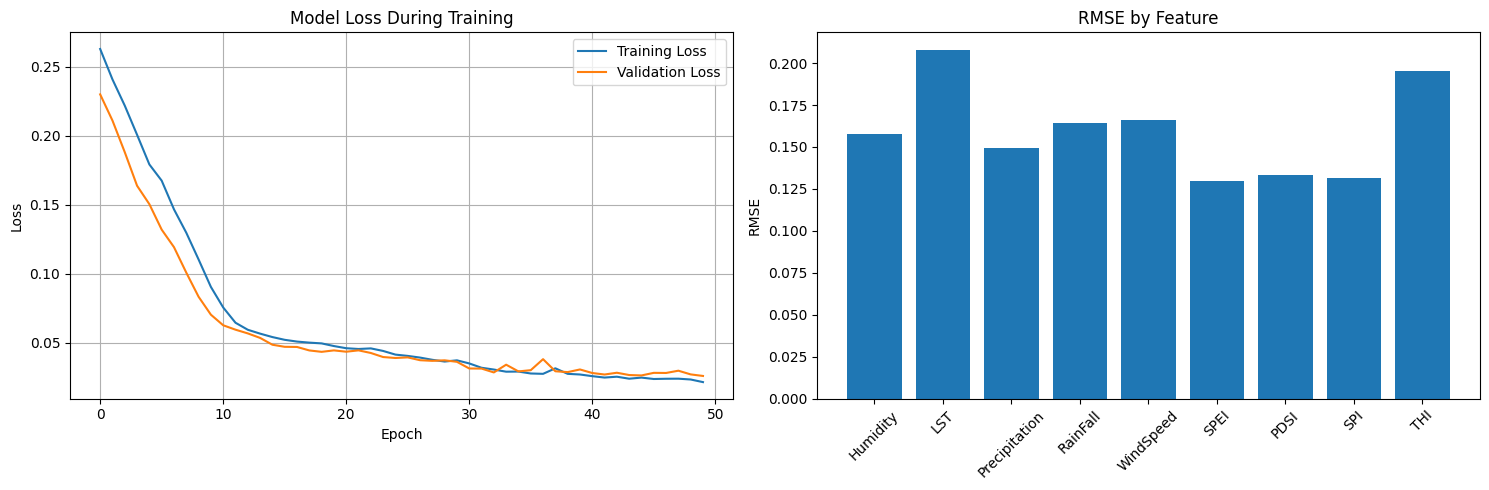

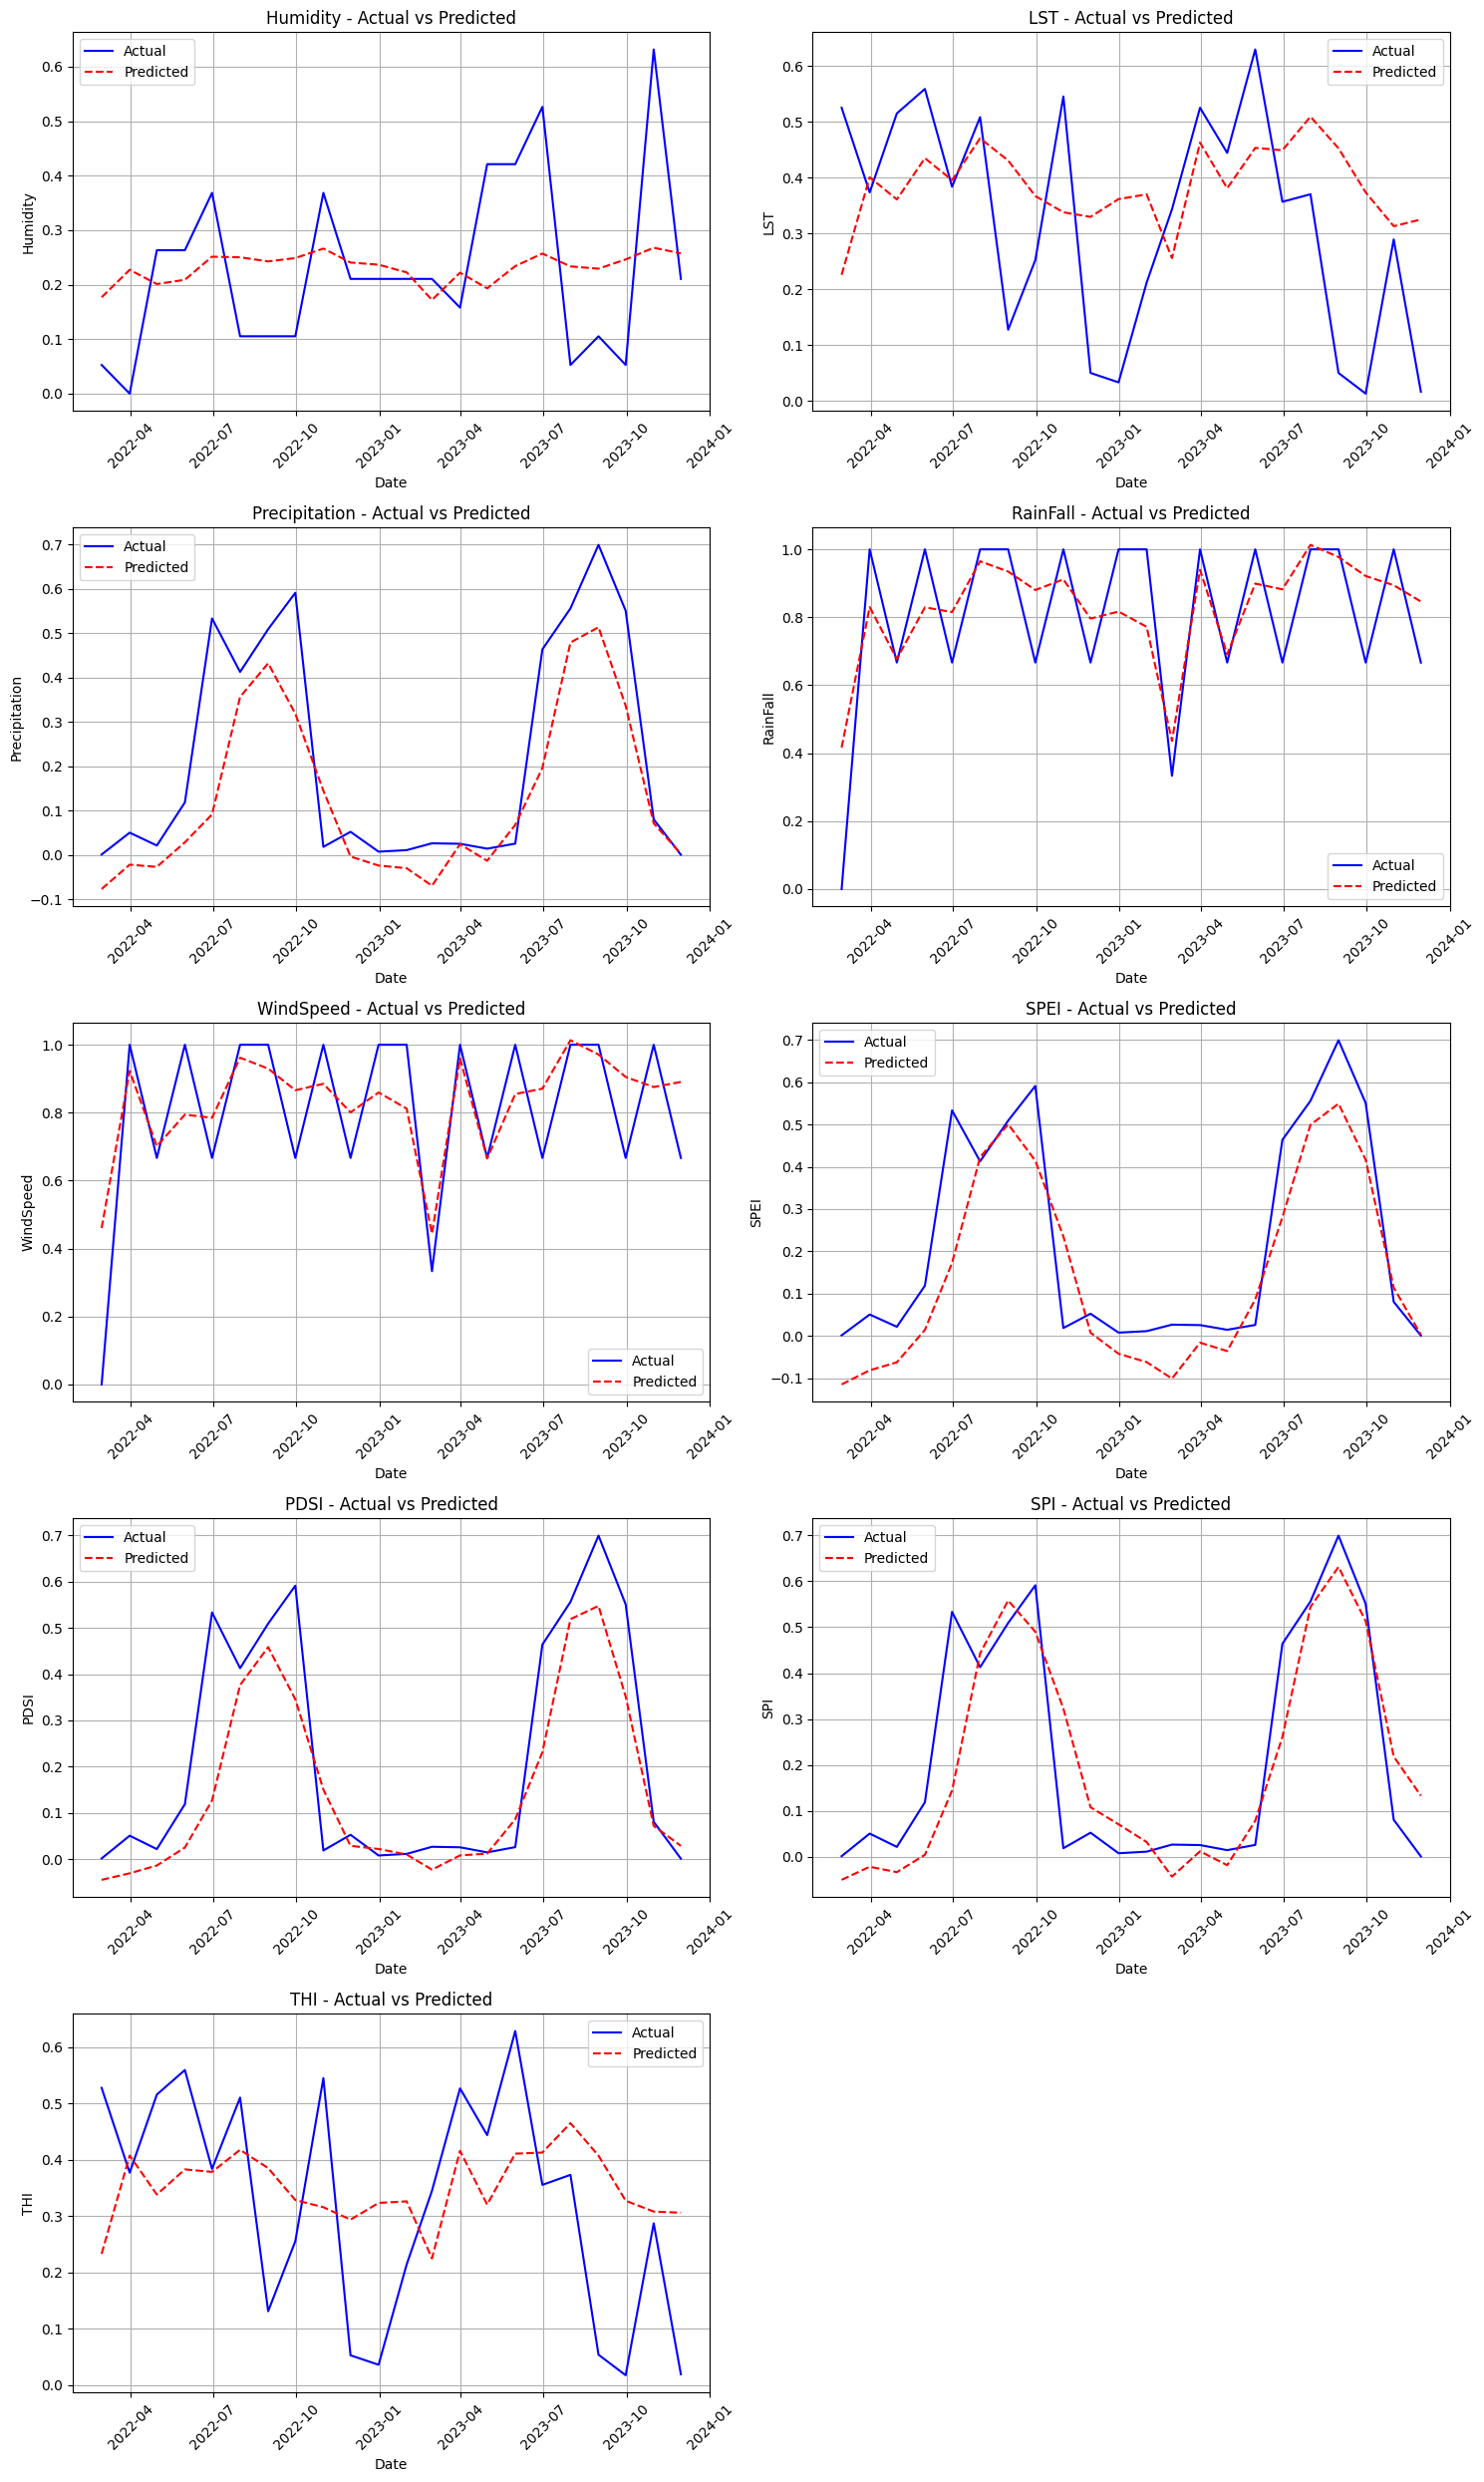

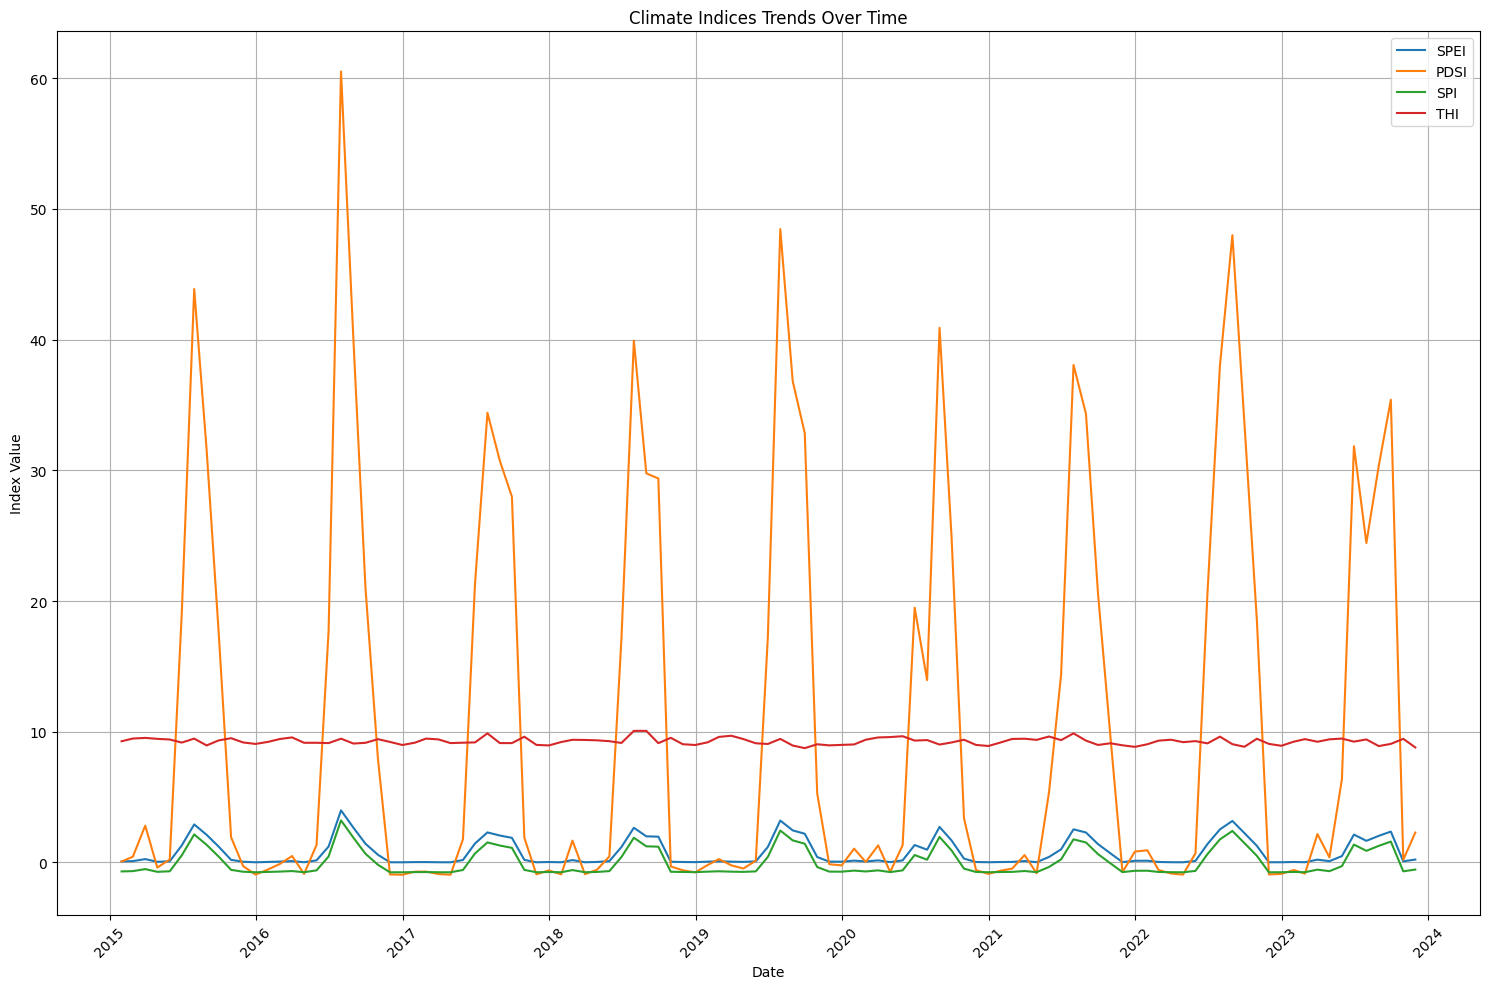

Making future predictions...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Saving model and results...
Analysis complete!


In [4]:
# Main Execution
def main():
    # Load data
    print("Loading data...")
    data = load_data()

    # Calculate climate indices
    print("Calculating climate indices...")
    indices = calculate_climate_indices(data)

    # Prepare data for LSTM
    print("Preparing data for LSTM...")
    X, y, scaler, feature_names = prepare_data_for_lstm(data, indices)

    # Train and evaluate model
    print("Training and evaluating model...")
    model, history, rmse_scores, predictions = train_and_evaluate_model(X, y, feature_names)

    # Create dates for plotting
    dates = pd.date_range(start='2015-01-01', periods=len(y), freq='M')

    # Ensure alignment between predictions and dates
    plot_dates = dates[-len(predictions):]  # Align dates with predictions

    # Plot results
    print("Plotting results...")
    plot_training_metrics(history, rmse_scores)
    plot_predictions(y[-len(predictions):], predictions, feature_names, plot_dates)

    # For climate indices, ensure alignment with `dates`
    indices_dates = dates[:len(indices)]  # Use only the portion that matches indices length
    plot_climate_indices_trends(indices, indices_dates)


    # Make future predictions
    print("Making future predictions...")
    future_steps = 12  # Predict next 12 months
    future_pred = predict_future(model, X[-1], future_steps, scaler, feature_names)

    # Save model and results
    print("Saving model and results...")
    model.save('output/climate_model.h5')
    future_pred.to_csv('output/future_predictions.csv')

    print("Analysis complete!")

if __name__ == "__main__":
    main()

## Load data

In [6]:
# Load data
print("Loading data...")
data = load_data()

# Calculate climate indices
print("Calculating climate indices...")
indices = calculate_climate_indices(data)

# Prepare data for LSTM
print("Preparing data for LSTM...")
X, y, scaler, feature_names = prepare_data_for_lstm(data, indices)

# Train and evaluate model
print("Training and evaluating model...")
model, history, rmse_scores, predictions = train_and_evaluate_model(X, y, feature_names)

Loading data...
Calculating climate indices...
Preparing data for LSTM...
Training and evaluating model...
Epoch 1/50


c:\Users\hp\MyCodingEnv\Capstone\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 237ms/step - loss: 0.2635 - mse: 0.2635 - val_loss: 0.2241 - val_mse: 0.2241
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2366 - mse: 0.2366 - val_loss: 0.1970 - val_mse: 0.1970
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.2007 - mse: 0.2007 - val_loss: 0.1592 - val_mse: 0.1592
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1615 - mse: 0.1615 - val_loss: 0.1078 - val_mse: 0.1078
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.1039 - mse: 0.1039 - val_loss: 0.1071 - val_mse: 0.1071
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.1097 - mse: 0.1097 - val_loss: 0.0765 - val_mse: 0.0765
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0818 - mse: 0.0818 - val_loss: 0.0754 - val_mse: 0.0754
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0806 - mse: 0.0806 - val_loss: 0.0721 - val_mse: 0.0721
Epoch 9/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0736 - mse: 0.0736 - val_loss: 

## Visualization and Analysis

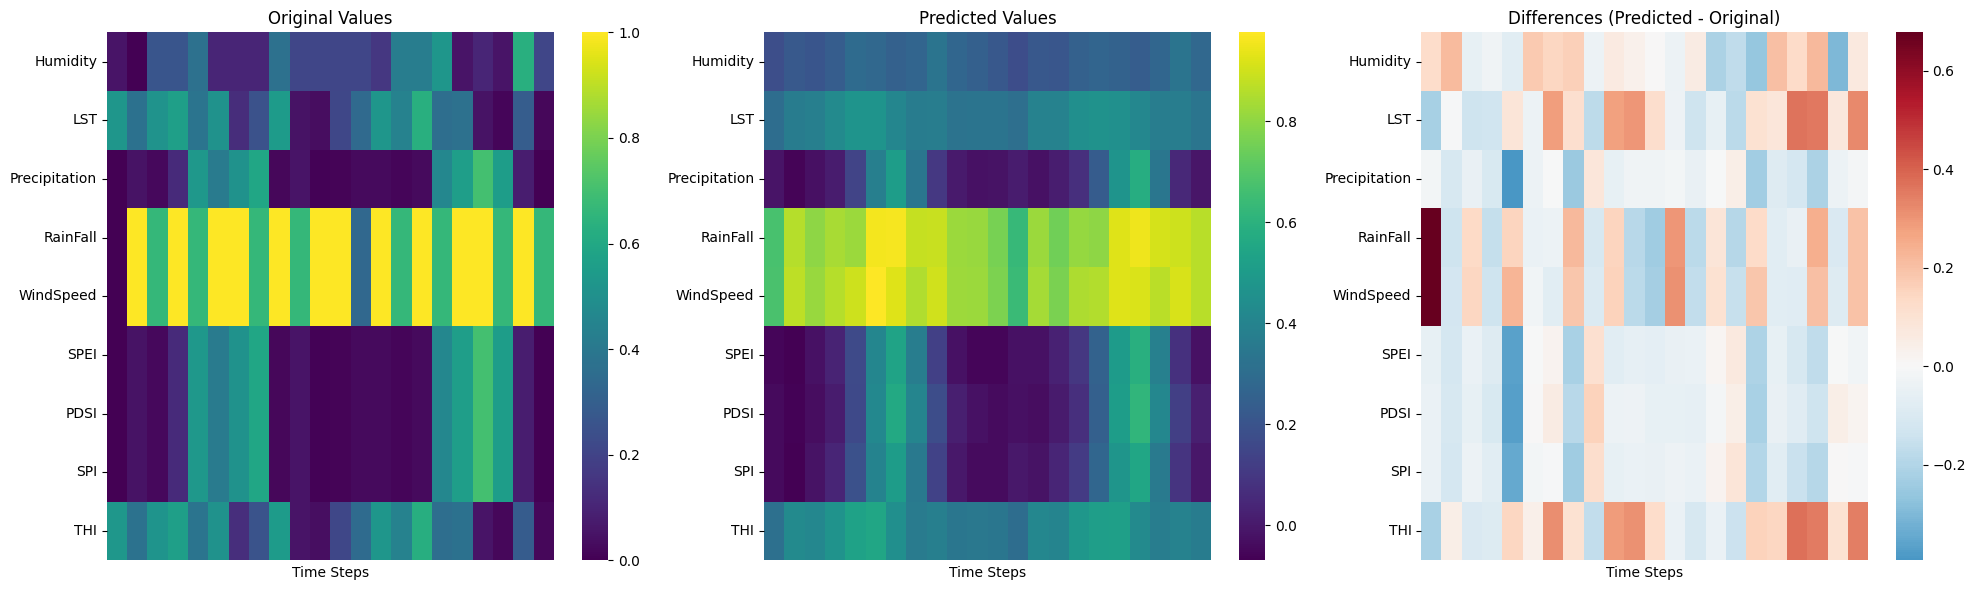

In [7]:
# Get test data and predictions
test_size = len(predictions)  # Number of test samples
y_test = y[-test_size:]  # Get corresponding actual values

# Select a portion of the data to visualize (e.g., last 50 timesteps)
n_timesteps = 50  # Adjust this number based on how many timesteps you want to show
original_data = y_test[-n_timesteps:]
predicted_data = predictions[-n_timesteps:]

# Import and use the heatmap function
import sys
sys.path.append("c:/Users/hp/MyCodingEnv/Capstone")

# Now try importing the visualization module
from visualization.heatmap_utils import plot_feature_comparison_heatmap

# Rest of your code remains the same
fig = plot_feature_comparison_heatmap(original_data, predicted_data, feature_names)
plt.show()

## Debug model architecture

In [27]:
# Debug model architecture
print("\nModel Architecture:")
model.summary()

# Debug data shapes
print("\nInput/Output Shapes:")
print("Model input shape:", model.input_shape)
print("Model output shape:", model.output_shape)
print("X shape:", X.shape)
print("y shape:", y.shape)

# Debug last sequence
print("\nLast Sequence Info:")
print("Last X sequence shape:", X[-1].shape)
print("Last y value shape:", y[-1].shape)
print("Feature names:", feature_names)
print("Number of features:", len(feature_names))


Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 12, 128)        │        70,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │           297 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 367,325 (1.40 MB)

 Trainable params: 122,441 (478.29 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 244,884 (956.58 KB)


Input/Output Shapes:
Model input shape: (None, 12, 9)
Model output shape: (None, 9)
X shape: (107, 12, 9)
y shape: (107, 9)

Last Sequence Info:
Last X sequence shape: (12, 9)
Last y value shape: (9,)
Feature names: Index(['Humidity', 'LST', 'Precipitation', 'RainFall', 'WindSpeed', 'SPEI',
       'PDSI', 'SPI', 'THI'],
      dtype='object')
Number of features: 9


## Future Prediction


Making future predictions...
Input sequence shape: (1, 12, 9)
Predictions shape: (12, 9)


C:\Users\hp\AppData\Local\Temp\ipykernel_8208\383068957.py:35: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  future_dates = pd.date_range(start=future_start_date, periods=future_steps, freq='M')
C:\Users\hp\AppData\Local\Temp\ipykernel_8208\383068957.py:49: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  historical_dates = pd.date_range(end=historical_end_date, periods=24, freq='M')
C:\Users\hp\AppData\Local\Temp\ipykernel_8208\383068957.py:49: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  historical_dates = pd.date_range(end=historical_end_date, periods=24, freq='M')
C:\Users\hp\AppData\Local\Temp\ipykernel_8208\383068957.py:49: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  historical_dates = pd.date_range(end=historical_end_date, periods=24, freq='M')
C:\Users\hp\AppDat

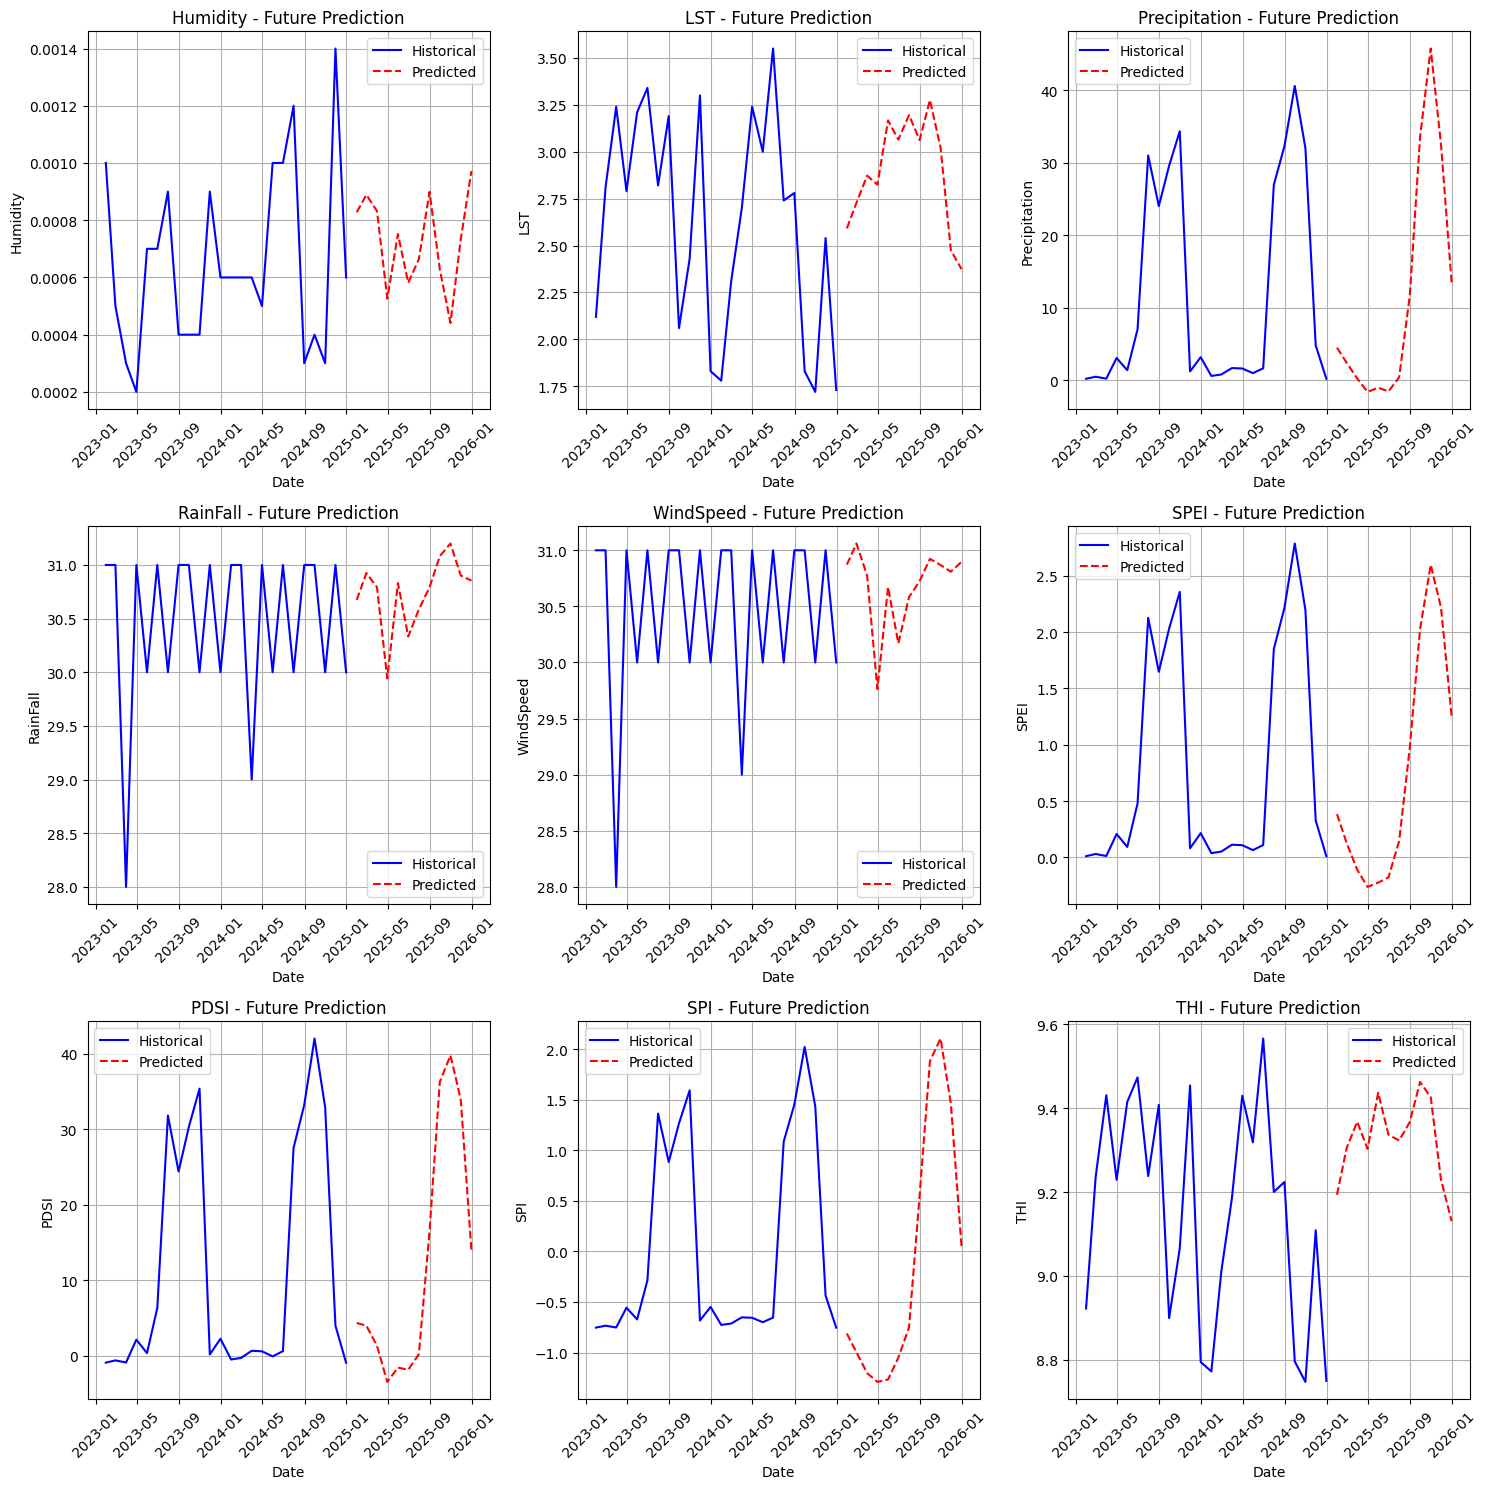


Predicted values (Jan 2025 - Dec 2025):
            Humidity       LST  Precipitation   RainFall  WindSpeed      SPEI  \
2025-01-31  0.000828  2.591597       4.467061  30.674217  30.871864  0.384352   
2025-02-28  0.000889  2.728085       2.388324  30.924116  31.060455  0.130662   
2025-03-31  0.000832  2.872185       0.202466  30.792923  30.774914 -0.109380   
2025-04-30  0.000526  2.824312      -1.644111  29.942614  29.763010 -0.261221   
2025-05-31  0.000752  3.167077      -1.057347  30.831465  30.672951 -0.223147   
2025-06-30  0.000581  3.064277      -1.571751  30.333248  30.170353 -0.177146   
2025-07-31  0.000664  3.195279       0.366006  30.586624  30.582367  0.145633   
2025-08-31  0.000899  3.062510      11.636956  30.791222  30.725174  0.972068   
2025-09-30  0.000628  3.275768      33.540512  31.081802  30.923588  2.025179   
2025-10-31  0.000441  3.020905      45.781548  31.200024  30.868248  2.597306   
2025-11-30  0.000733  2.474355      32.516666  30.901318  30.809437 

In [35]:
# Make future predictions
print("\nMaking future predictions...")
future_steps = 12  # Predict next 12 months
look_back = 12  # Same as used in prepare_data_for_lstm

# Get the last sequence (just one sequence)
input_sequence = X[-1].reshape(1, look_back, 9)  # Take only the last sequence and reshape
print("Input sequence shape:", input_sequence.shape)

# Make predictions one at a time
predictions = []
current_sequence = input_sequence.copy()

for _ in range(future_steps):
    # Get prediction for current sequence
    pred = model.predict(current_sequence, verbose=0)
    predictions.append(pred[0])  # Add the prediction (shape: (9,))
    
    # Update sequence for next prediction
    current_sequence = current_sequence.reshape(look_back, 9)  # Remove batch dimension
    current_sequence = np.roll(current_sequence, -1, axis=0)  # Shift all rows up by 1
    current_sequence[-1] = pred[0]  # Add new prediction as last row
    current_sequence = current_sequence.reshape(1, look_back, 9)  # Add batch dimension back

# Convert predictions to array
predictions = np.array(predictions)
print("Predictions shape:", predictions.shape)

# Create date ranges for plotting
# Historical dates end at December 2024
historical_end_date = pd.Timestamp('2024-12-31')
# Future predictions start from January 2025
future_start_date = historical_end_date + pd.DateOffset(days=1)
# Create future dates
future_dates = pd.date_range(start=future_start_date, periods=future_steps, freq='M')

# Calculate number of rows and columns needed for subplots
n_features = len(feature_names)
n_cols = 3  # We'll use 3 columns
n_rows = (n_features + n_cols - 1) // n_cols  # Ceiling division to get number of rows

# Plot predictions
plt.figure(figsize=(15, 5*n_rows))
for i, feature in enumerate(feature_names):
    plt.subplot(n_rows, n_cols, i+1)
    
    # Plot historical data (last 24 months)
    historical_data = scaler.inverse_transform(y[-24:])
    historical_dates = pd.date_range(end=historical_end_date, periods=24, freq='M')
    plt.plot(historical_dates, historical_data[:, i], label='Historical', color='blue')
    
    # Plot predictions
    future_predictions = scaler.inverse_transform(predictions)
    plt.plot(future_dates, future_predictions[:, i], label='Predicted', color='red', linestyle='--')
    
    plt.title(f'{feature} - Future Prediction')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print predicted values
print("\nPredicted values (Jan 2025 - Dec 2025):")
future_predictions_df = pd.DataFrame(scaler.inverse_transform(predictions), 
                                   columns=feature_names,
                                   index=future_dates)
print(future_predictions_df)

## Time Series Animation

C:\Users\hp\AppData\Local\Temp\ipykernel_8208\2343657533.py:109: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  historical_dates=pd.date_range(end='2024-12-31', periods=24, freq='M'),


Creating animation for Humidity...
Creating animation for LST...
Creating animation for Precipitation...
Creating animation for RainFall...
Creating animation for WindSpeed...
Creating animation for SPEI...
Creating animation for PDSI...
Creating animation for SPI...
Creating animation for THI...

Animations have been saved in the 'animations' directory.
Each feature has its own GIF file showing:
1. Historical and predicted values together
2. Predicted values for 2025
3. Difference between predicted and historical values

Animation for Humidity:



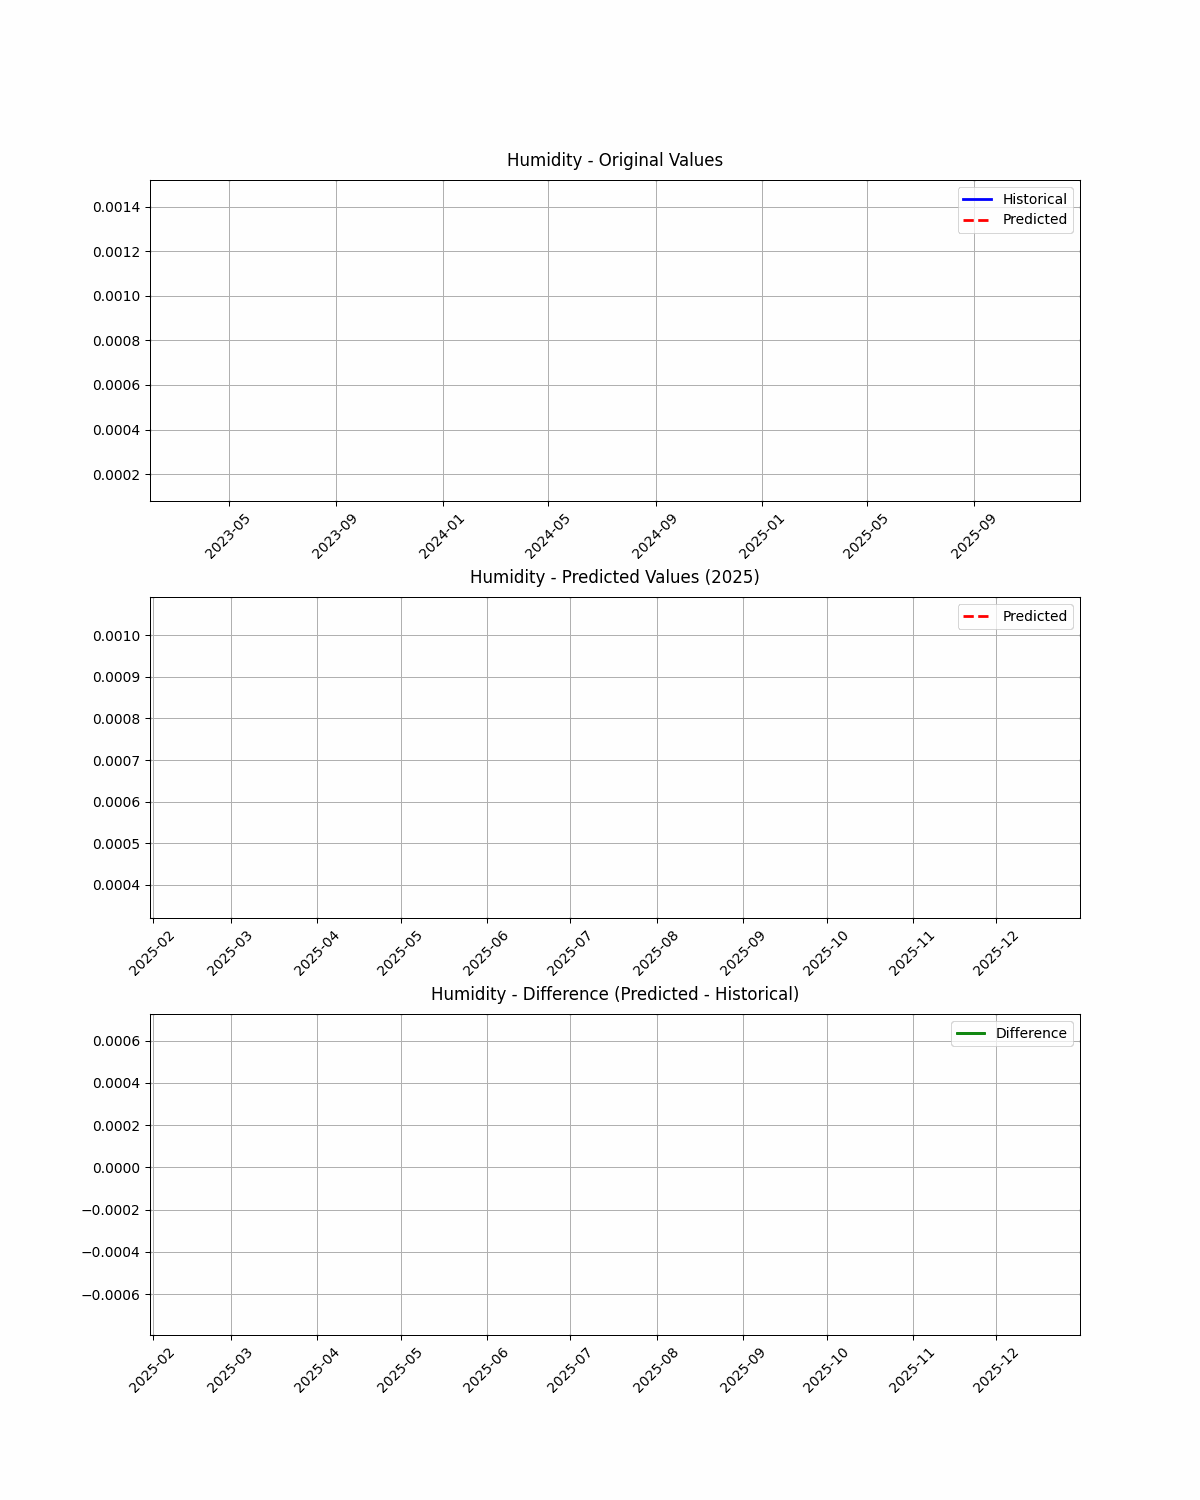


Animation for LST:



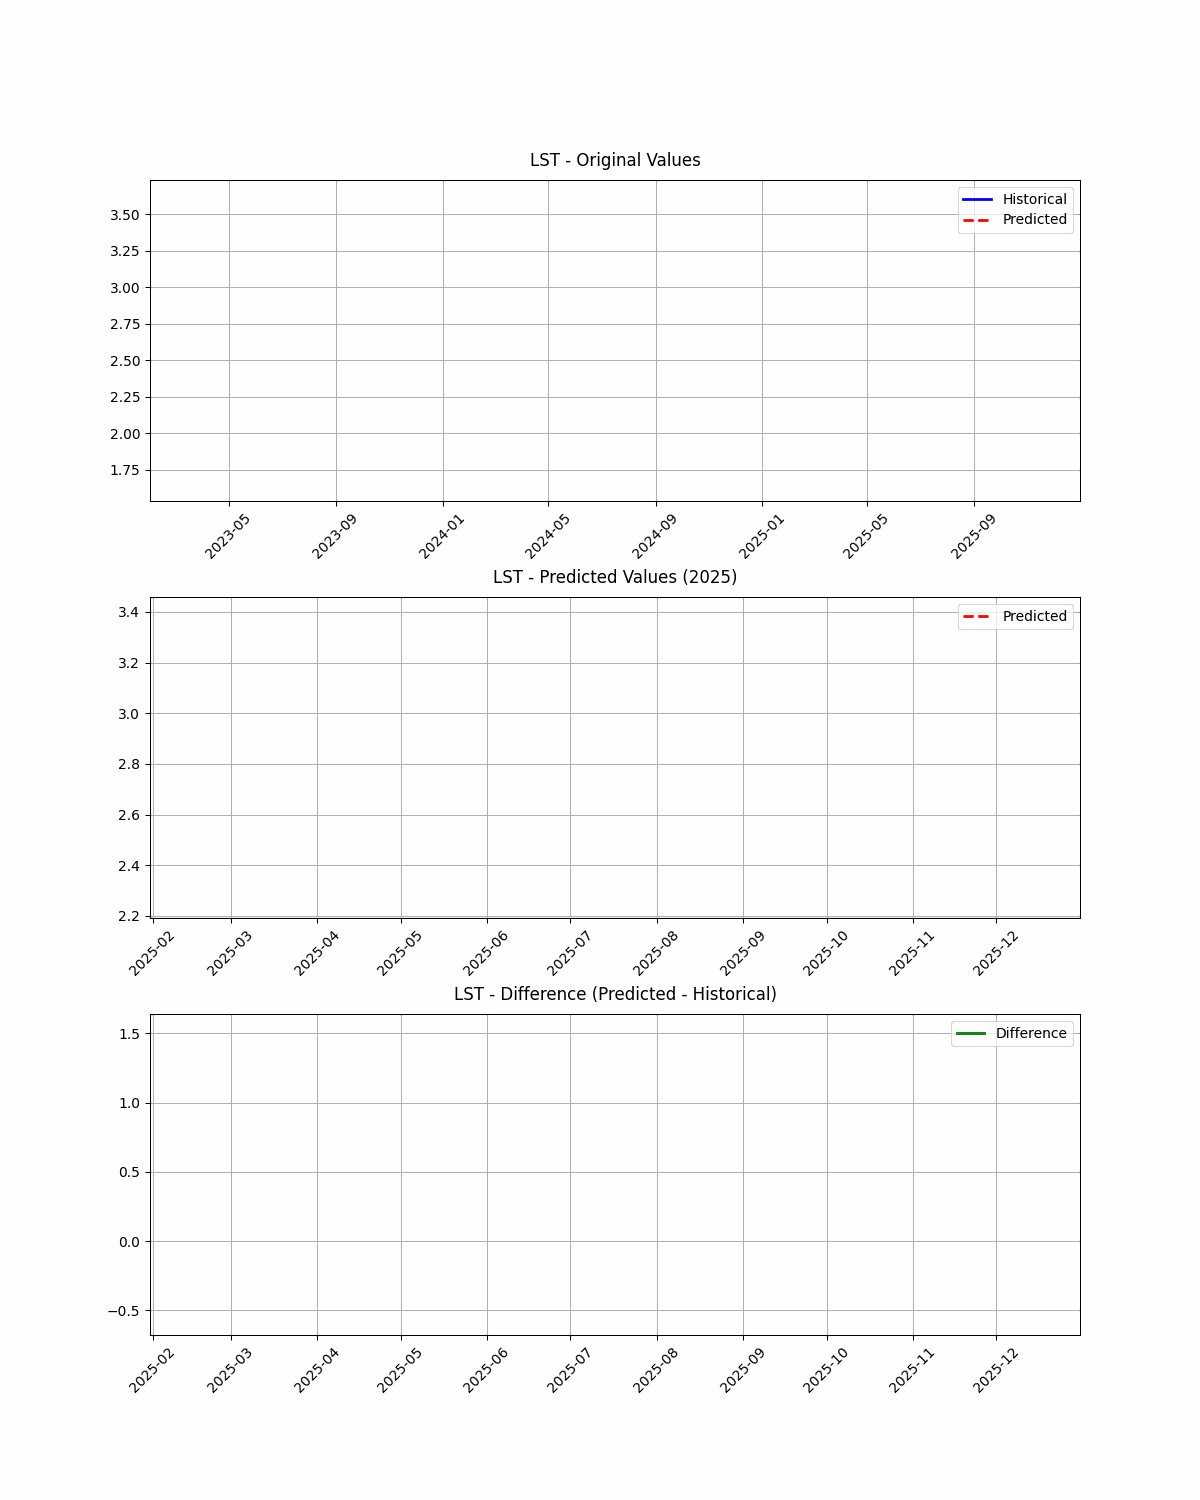


Animation for Precipitation:



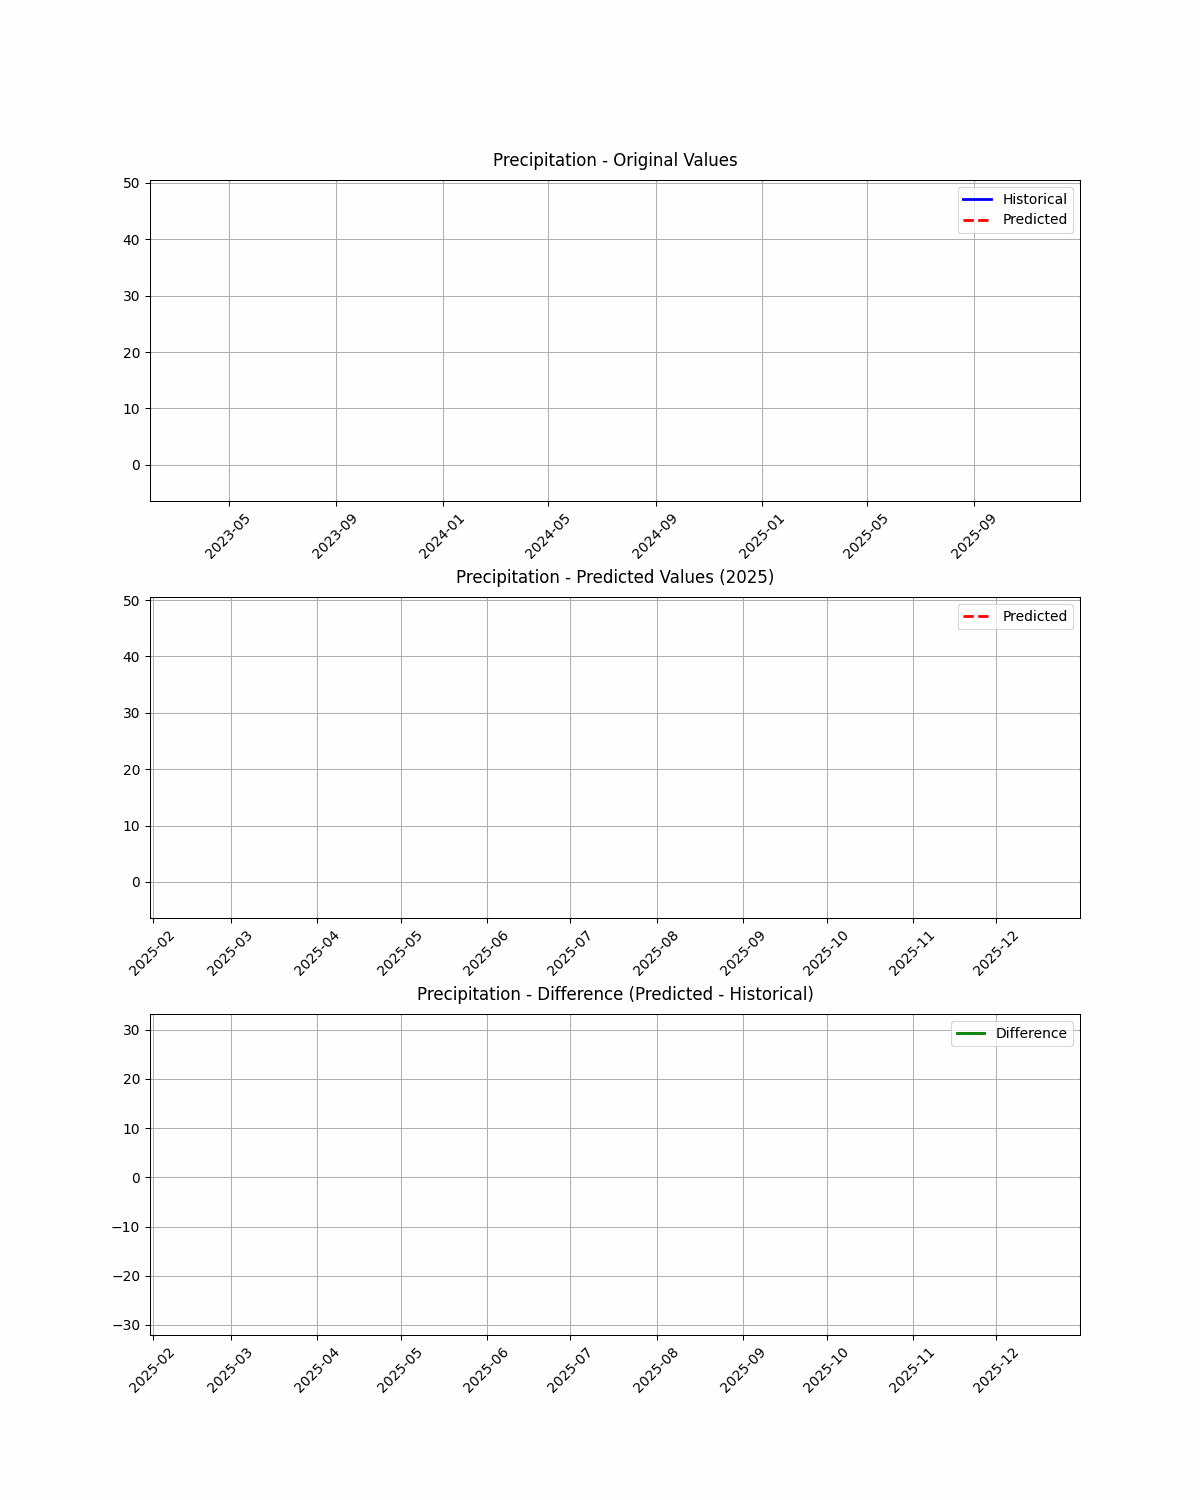


Animation for RainFall:



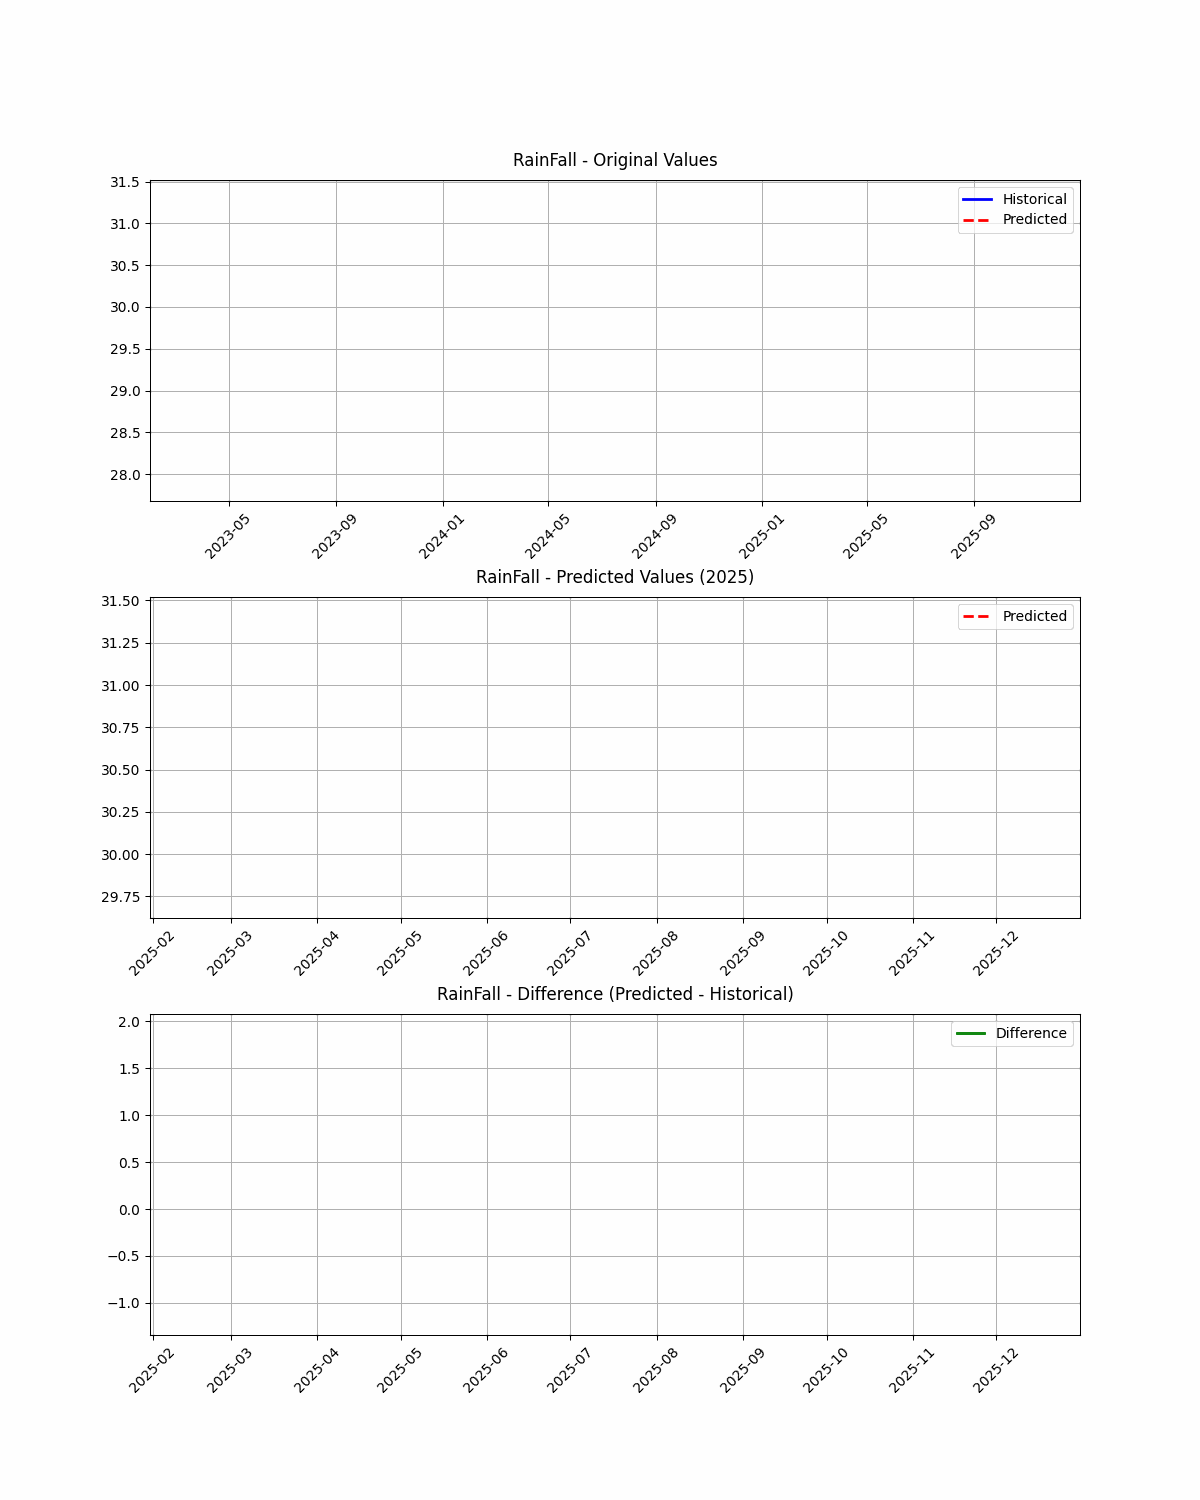


Animation for WindSpeed:



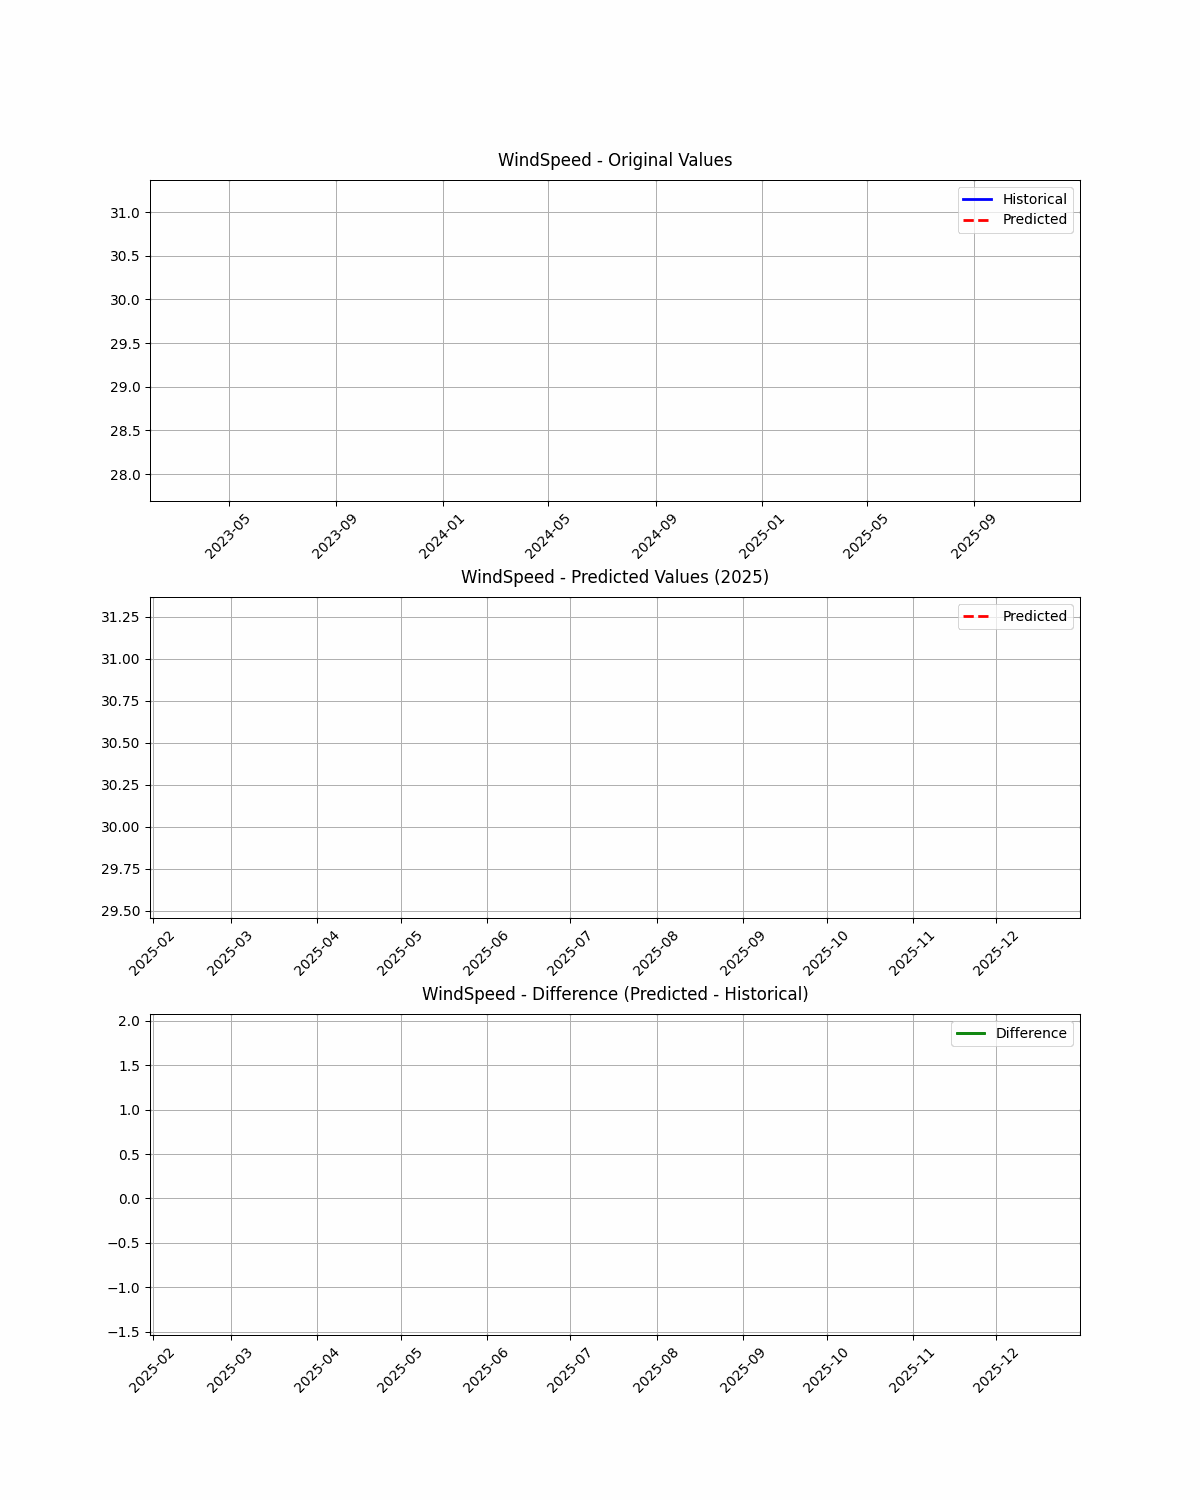


Animation for SPEI:



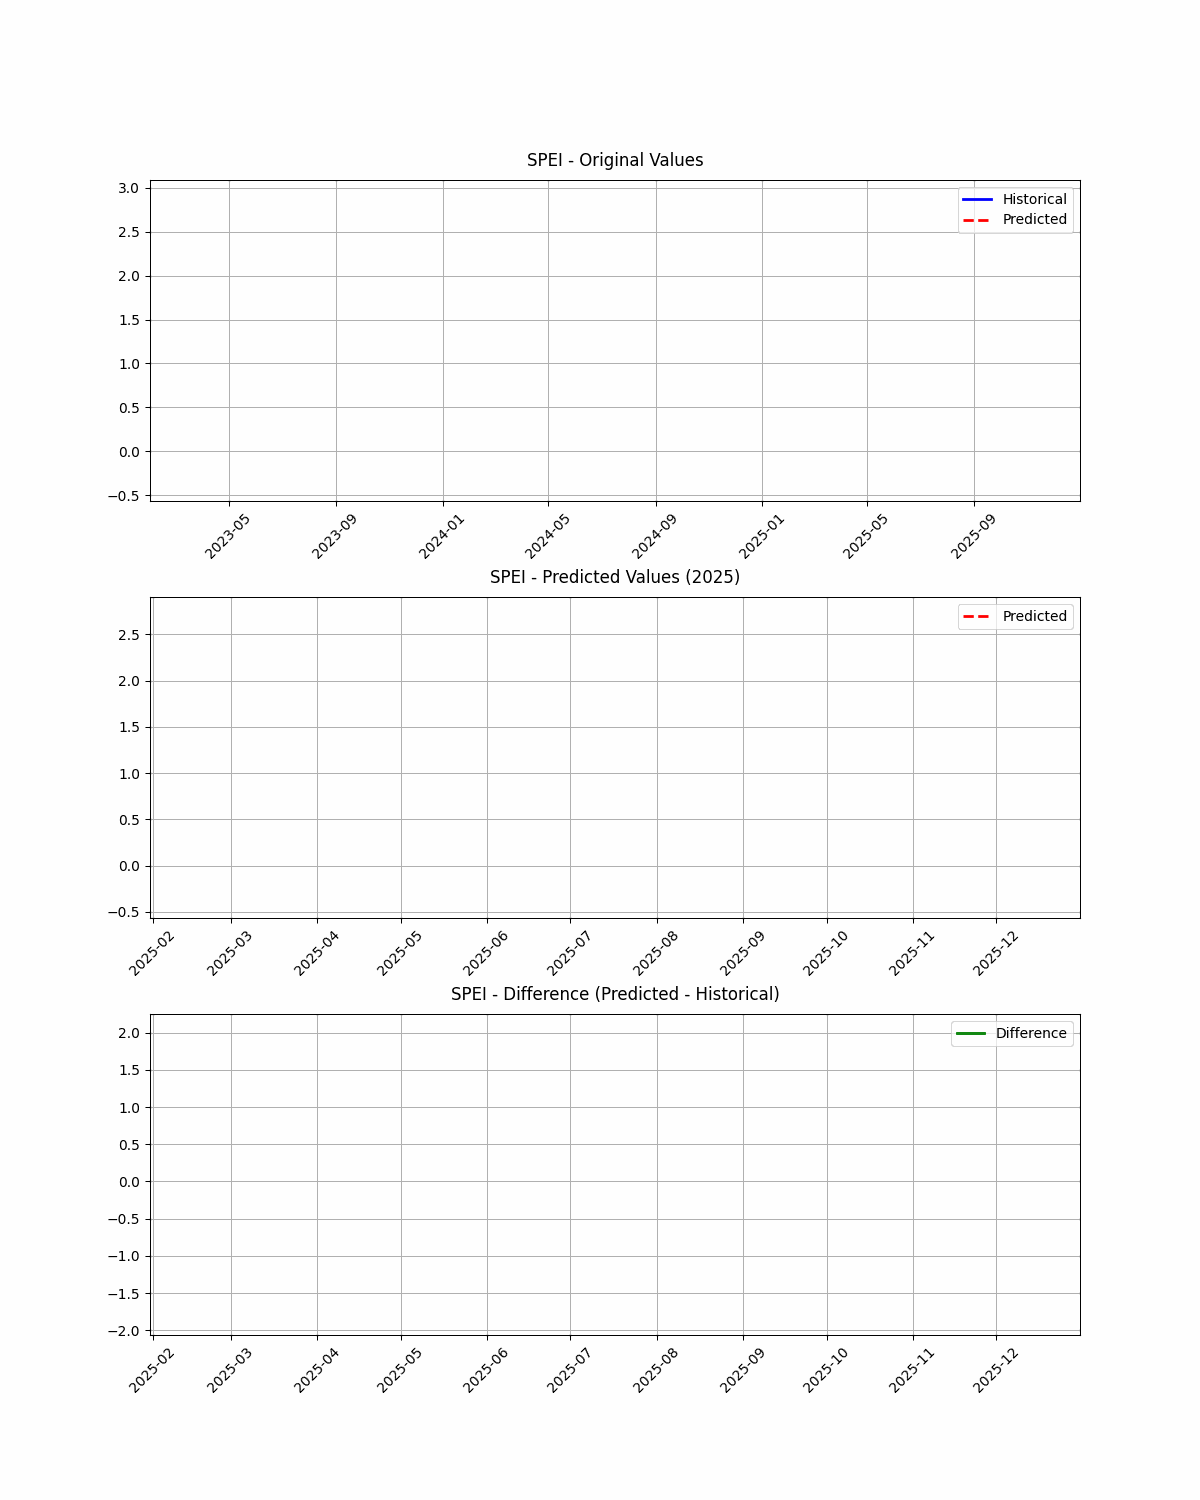


Animation for PDSI:



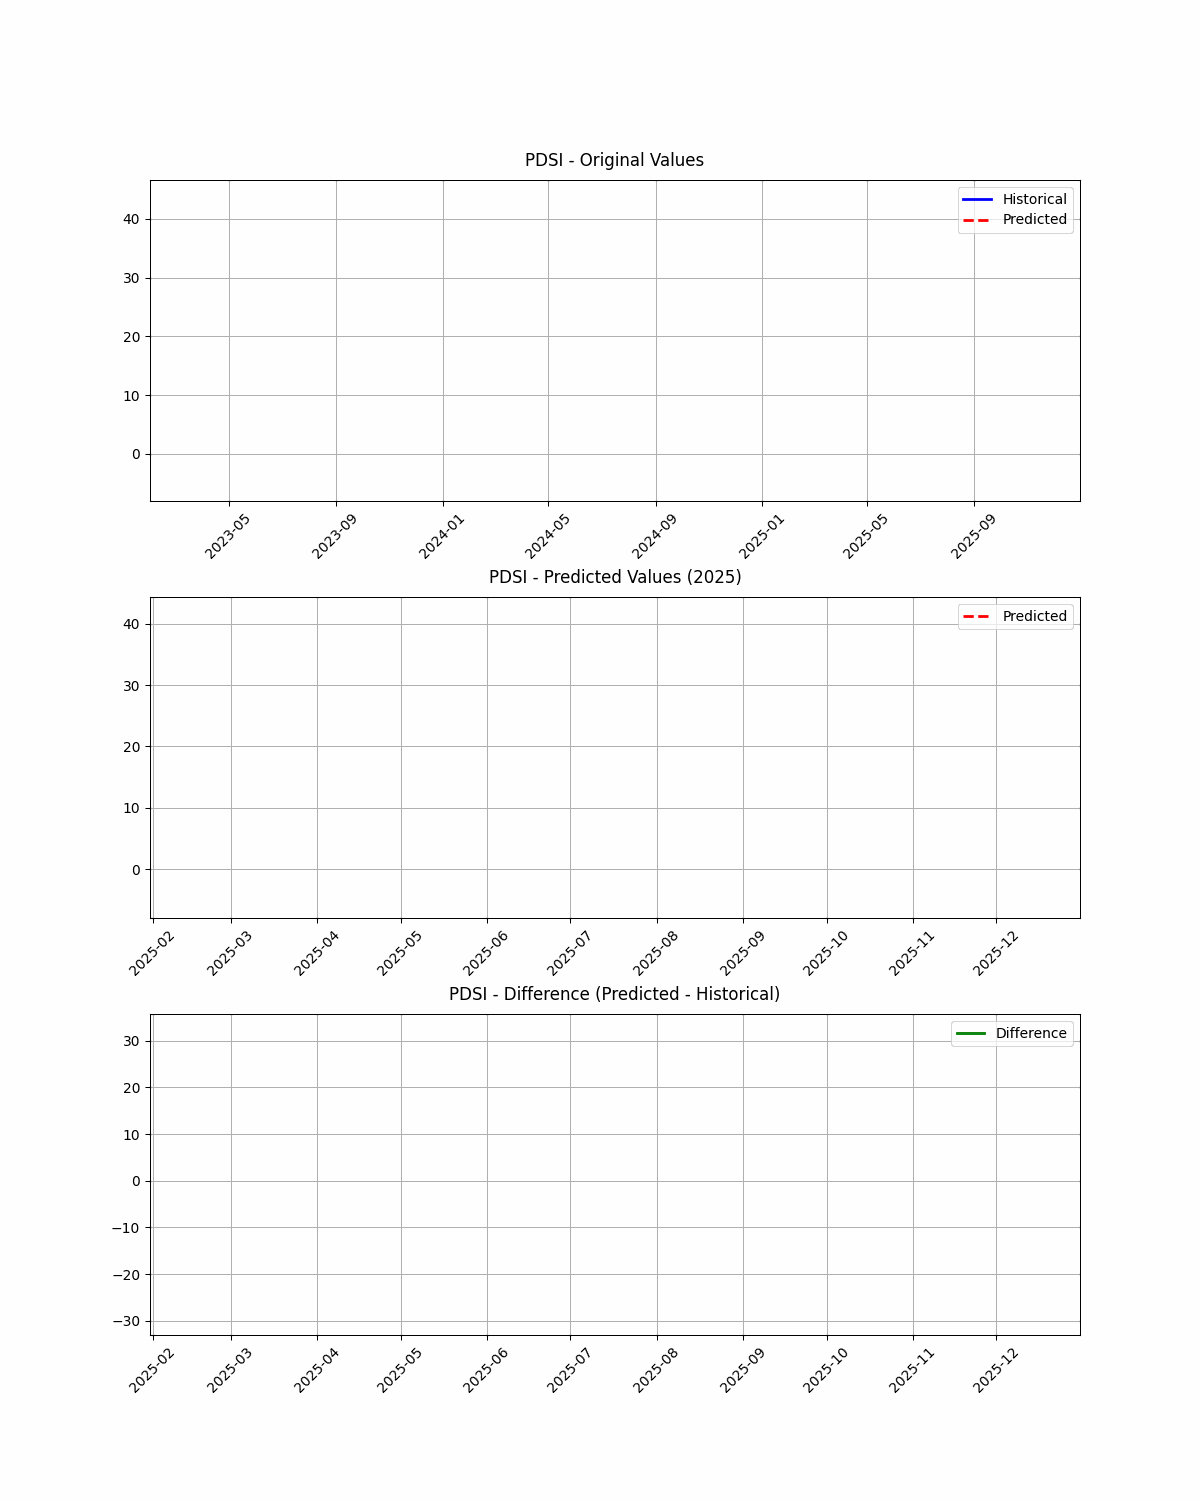


Animation for SPI:



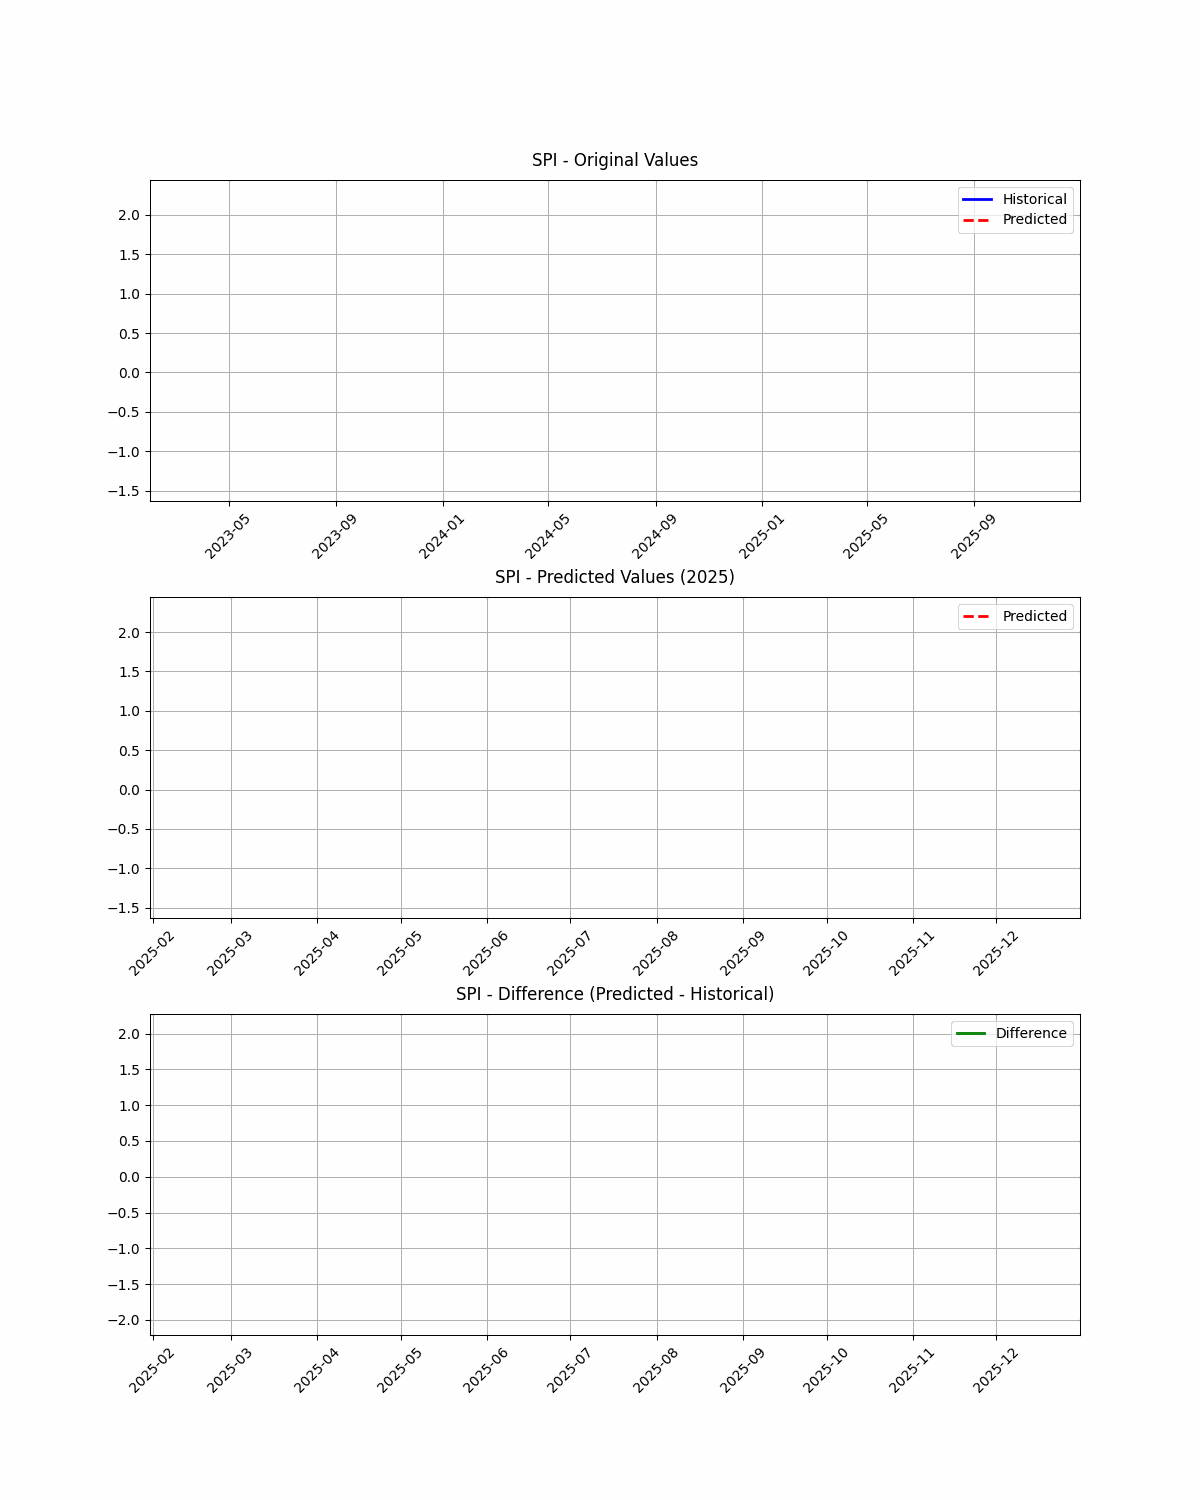


Animation for THI:



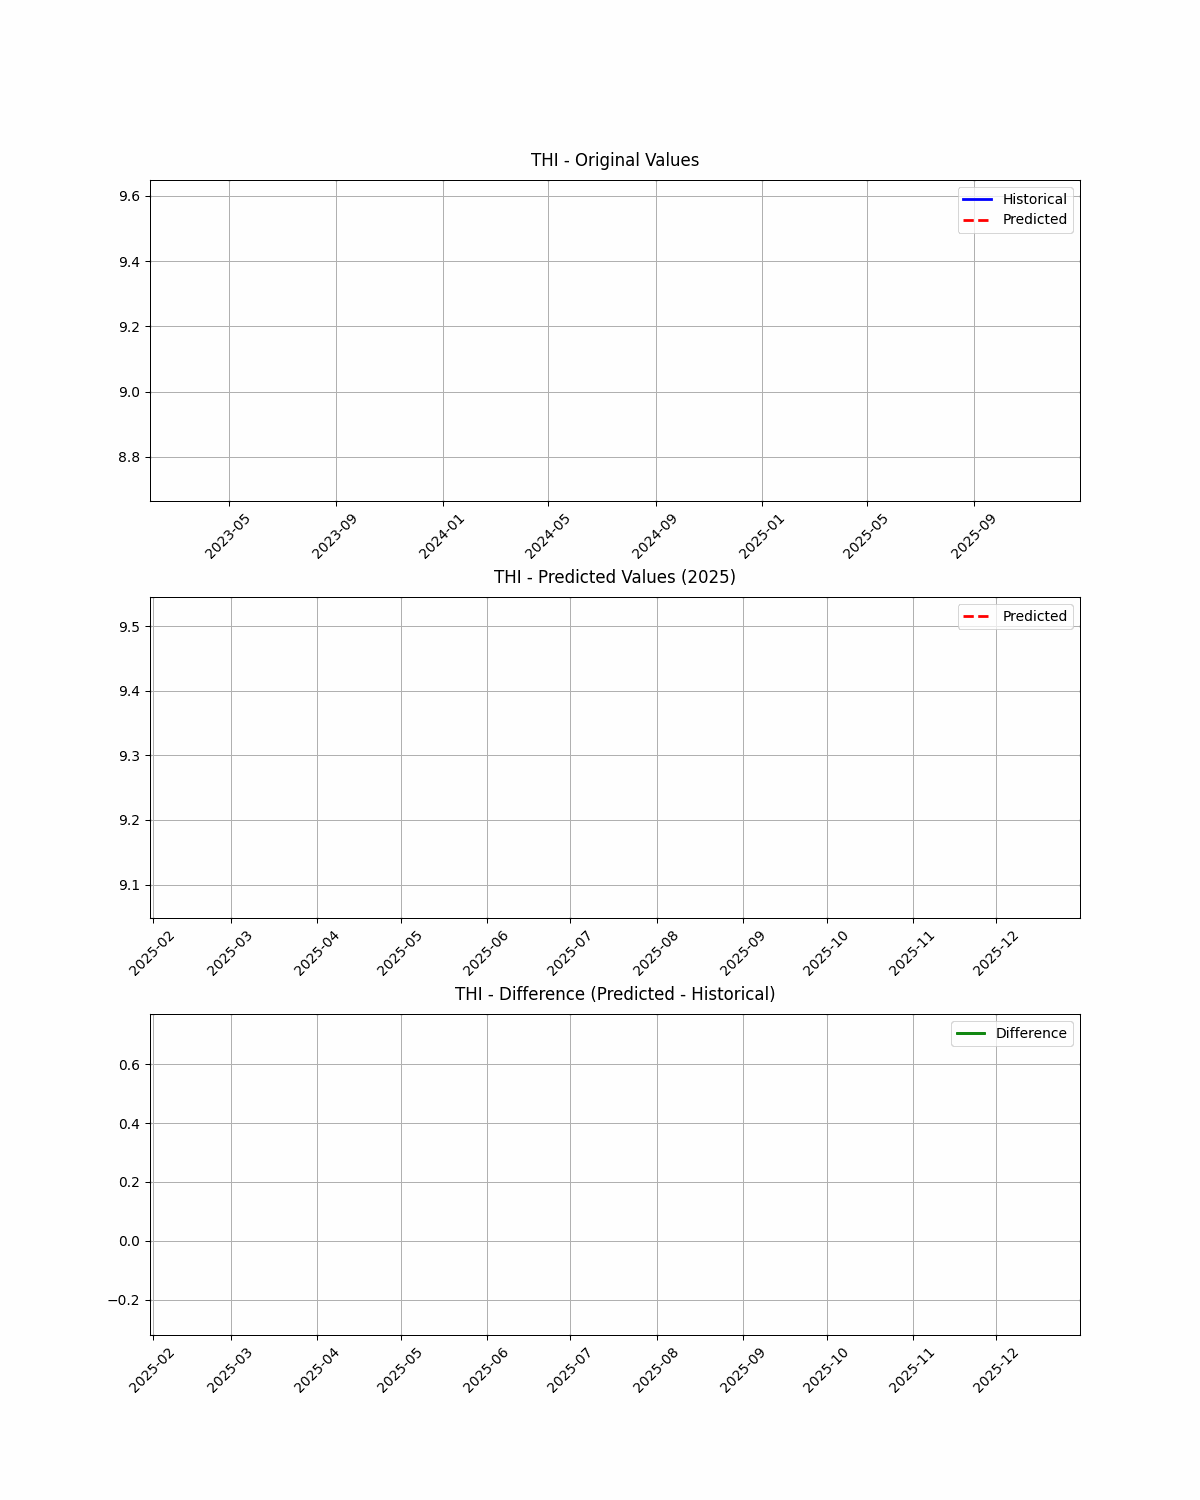

In [39]:
import matplotlib.animation as animation
from IPython.display import HTML, display
import base64
import os
import matplotlib.dates as mdates

def create_animated_time_series(historical_dates, historical_data, 
                              future_dates, future_predictions, 
                              feature_names, save_path='animations'):
    """Create animated time series plots for each feature."""
    
    # Create directory if it doesn't exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # Combine dates and data
    all_dates = pd.concat([pd.Series(historical_dates), pd.Series(future_dates)])
    
    for i, feature in enumerate(feature_names):
        print(f"Creating animation for {feature}...")
        
        # Get the data for this feature
        historical_feature = historical_data[:, i]
        predicted_feature = future_predictions[:, i]
        
        # Skip if all values are zero
        if np.all(historical_feature == 0) and np.all(predicted_feature == 0):
            print(f"Warning: All values for {feature} are zero. Skipping animation.")
            continue
        
        # Create figure and axis
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
        plt.subplots_adjust(hspace=0.3)
        
        # Calculate proper y-axis limits
        min_val = min(historical_feature.min(), predicted_feature.min())
        max_val = max(historical_feature.max(), predicted_feature.max())
        y_margin = (max_val - min_val) * 0.1  # 10% margin
        
        # Original Data Plot
        line1, = ax1.plot([], [], 'b-', label='Historical', linewidth=2)
        line1_pred, = ax1.plot([], [], 'r--', label='Predicted', linewidth=2)
        ax1.set_xlim(all_dates.min(), all_dates.max())
        ax1.set_ylim(min_val - y_margin, max_val + y_margin)
        ax1.set_title(f'{feature} - Original Values', fontsize=12, pad=10)
        ax1.grid(True)
        ax1.legend(fontsize=10)
        
        # Predicted Data Plot
        line2, = ax2.plot([], [], 'r--', label='Predicted', linewidth=2)
        ax2.set_xlim(future_dates.min(), future_dates.max())
        ax2.set_ylim(predicted_feature.min() - y_margin, predicted_feature.max() + y_margin)
        ax2.set_title(f'{feature} - Predicted Values (2025)', fontsize=12, pad=10)
        ax2.grid(True)
        ax2.legend(fontsize=10)
        
        # Difference Plot
        line3, = ax3.plot([], [], 'g-', label='Difference', linewidth=2)
        ax3.set_xlim(future_dates.min(), future_dates.max())
        # Calculate difference between last historical values and predictions
        diff_data = predicted_feature - historical_feature[-len(predicted_feature):]
        diff_margin = (diff_data.max() - diff_data.min()) * 0.1
        ax3.set_ylim(diff_data.min() - diff_margin, diff_data.max() + diff_margin)
        ax3.set_title(f'{feature} - Difference (Predicted - Historical)', fontsize=12, pad=10)
        ax3.grid(True)
        ax3.legend(fontsize=10)
        
        # Format dates on x-axis
        for ax in [ax1, ax2, ax3]:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
            ax.tick_params(axis='both', which='major', labelsize=10)
        
        def init():
            line1.set_data([], [])
            line1_pred.set_data([], [])
            line2.set_data([], [])
            line3.set_data([], [])
            return line1, line1_pred, line2, line3
        
        def animate(frame):
            # Original data animation
            line1.set_data(historical_dates[:frame], historical_feature[:frame])
            
            # Predicted data animation
            if frame > len(historical_dates):
                pred_frame = frame - len(historical_dates)
                line1_pred.set_data(future_dates[:pred_frame], predicted_feature[:pred_frame])
                line2.set_data(future_dates[:pred_frame], predicted_feature[:pred_frame])
                line3.set_data(future_dates[:pred_frame], diff_data[:pred_frame])
            
            return line1, line1_pred, line2, line3
        
        # Create animation with slower speed
        anim = animation.FuncAnimation(fig, animate, init_func=init,
                                     frames=len(historical_dates) + len(future_dates),
                                     interval=500,  # Increased from 100 to 500 ms
                                     repeat_delay=2000,  # 2 second delay before repeating
                                     blit=True)
        
        # Save animation with higher quality
        anim.save(f'{save_path}/{feature}_time_series.gif',
                 writer='pillow',
                 fps=2)  # Reduced fps for slower animation
        plt.close()

# Create the animations with the modified code
create_animated_time_series(
    historical_dates=pd.date_range(end='2024-12-31', periods=24, freq='M'),
    historical_data=scaler.inverse_transform(y[-24:]),
    future_dates=future_dates,
    future_predictions=scaler.inverse_transform(predictions),
    feature_names=feature_names
)

# Display a message about where to find the animations
print("\nAnimations have been saved in the 'animations' directory.")
print("Each feature has its own GIF file showing:")
print("1. Historical and predicted values together")
print("2. Predicted values for 2025")
print("3. Difference between predicted and historical values")

# Try to display animations in notebook
try:
    for feature in feature_names:
        print(f"\nAnimation for {feature}:")
        with open(f'animations/{feature}_time_series.gif', 'rb') as file:
            display(HTML(f'<img src="data:image/gif;base64,{base64.b64encode(file.read()).decode()}" />'))
except Exception as e:
    print(f"Note: Animations are saved but couldn't be displayed in the notebook. Error: {str(e)}")
    print("Please check the 'animations' folder for the GIF files.")

## MP Hitmap Animation 

Fetching MP boundary data...
Backup method failed: Extra data: line 1 column 4 (char 3)
Attempting to use GEE...
Successfully retrieved MP boundary data from GEE!
Creating animation...


C:\Users\hp\AppData\Local\Temp\ipykernel_8208\2558221721.py:158: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  historical_dates=pd.date_range(end='2024-12-31', periods=24, freq='M'),


Saving animation...
Processing frame 1/18
Processing frame 6/18
Processing frame 11/18
Processing frame 16/18
Animation saved successfully!



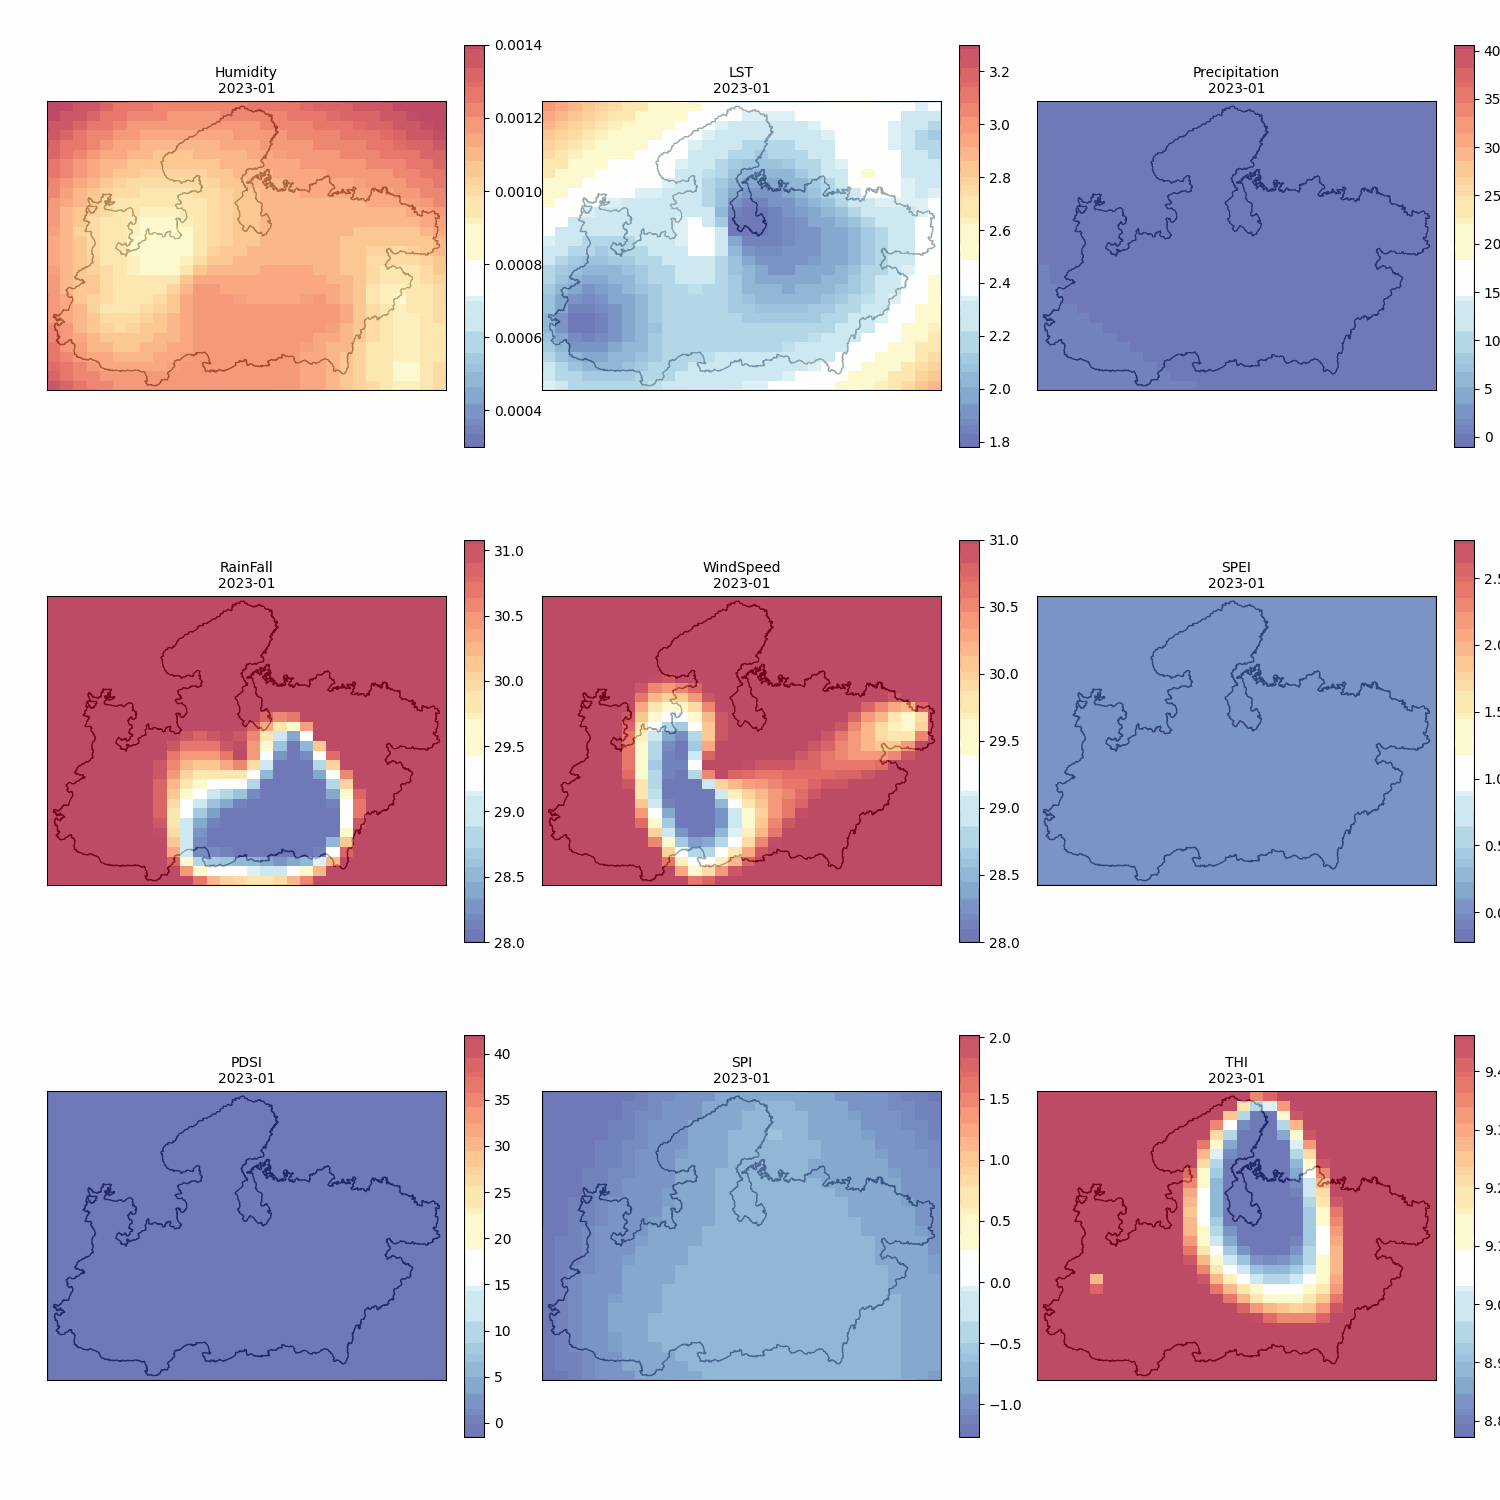

In [50]:
import ee
import geemap.foliumap as geemap
import geopandas as gpd
import json
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
from matplotlib.patches import Patch
import numpy as np
from scipy.interpolate import Rbf
import os
import base64
from IPython.display import HTML, display

def create_spatial_variation(base_value, bounds, n_points=30):  # Reduced points
    """Create spatially varying values across MP"""
    x = np.linspace(bounds[0], bounds[2], n_points)
    y = np.linspace(bounds[1], bounds[3], n_points)
    X, Y = np.meshgrid(x, y)
    
    n_controls = 8  # Reduced control points
    control_x = np.random.uniform(bounds[0], bounds[2], n_controls)
    control_y = np.random.uniform(bounds[1], bounds[3], n_controls)
    variation = base_value * 0.2
    control_values = base_value + np.random.uniform(-variation, variation, n_controls)
    
    rbf = Rbf(control_x, control_y, control_values, function='linear')  # Changed to linear for speed
    Z = rbf(X, Y)
    
    return X, Y, Z

def create_mp_animated_heatmap(historical_data, future_predictions, feature_names, 
                             historical_dates, future_dates, mp_gdf, 
                             save_path='animations_map'):
    """Create animated heatmaps overlaid on MP map for each climate feature."""
    
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    
    # Reduce the number of frames by taking every 2nd frame
    step = 2  # Take every 2nd frame
    all_data = np.vstack([historical_data[::step], future_predictions[::step]])
    all_dates = pd.concat([pd.Series(historical_dates[::step]), pd.Series(future_dates[::step])])
    bounds = mp_gdf.total_bounds
    
    # Create figure with 3x3 grid
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    axs = axs.ravel()
    
    # Hide unused subplots
    for i in range(len(feature_names), len(axs)):
        axs[i].set_visible(False)
    
    # Pre-calculate some values
    feature_norms = {}
    for i, feature in enumerate(feature_names):
        feature_data = all_data[:, i]
        feature_norms[i] = colors.Normalize(vmin=feature_data.min(), vmax=feature_data.max())
    
    def init():
        return []
    
    def animate(frame):
        artists = []
        for i, feature in enumerate(feature_names):
            if i >= len(axs):
                break
                
            ax = axs[i]
            ax.clear()
            
            # Plot MP boundary
            mp_gdf.plot(ax=ax, color='none', edgecolor='black', linewidth=1)
            
            # Get data and create spatial variation
            feature_data = all_data[:, i]
            X, Y, Z = create_spatial_variation(feature_data[frame], bounds)
            
            # Plot heatmap
            im = ax.pcolormesh(X, Y, Z, cmap=plt.cm.RdYlBu_r,
                             norm=feature_norms[i],
                             alpha=0.7)
            
            # Add colorbar (only if it doesn't exist)
            if frame == 0:
                plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            
            # Set title
            current_date = all_dates.iloc[frame].strftime('%Y-%m')
            title = f'{feature}\n{current_date}'
            if frame >= len(historical_dates[::step]):
                title += ' (Pred)'
            ax.set_title(title, fontsize=10)
            
            # Remove axes
            ax.set_xticks([])
            ax.set_yticks([])
            
            artists.append(im)
        
        if frame % 5 == 0:  # Print progress every 5 frames
            print(f"Processing frame {frame+1}/{len(all_dates)}")
        
        return artists
    
    # Create animation with slower timing
    print("Creating animation...")
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames=len(all_dates),
                                 interval=1000,  # Increased to 1 second per frame
                                 repeat_delay=3000,  # Increased to 3 seconds between repeats
                                 blit=True)
    
    # Adjust layout
    plt.tight_layout()
    
    # Save animation with slower fps
    print("Saving animation...")
    anim.save(f'{save_path}/combined_features_map.gif',
             writer='pillow',
             fps=1)  # Reduced to 1 frame per second
    plt.close()
    
    print("Animation saved successfully!")
    return f'{save_path}/combined_features_map.gif'

# Get MP boundary (using backup method first as it's faster)
print("Fetching MP boundary data...")
try:
    # Try backup method first
    mp_geojson_url = "https://raw.githubusercontent.com/HindustanTimesLabs/shapefiles/master/state_ut/madhya_pradesh.geojson"
    import requests
    response = requests.get(mp_geojson_url)
    mp_geojson = response.json()
    mp_gdf = gpd.GeoDataFrame.from_features(mp_geojson)
    mp_gdf.crs = "EPSG:4326"
    print("Successfully retrieved MP boundary data!")
except Exception as e:
    print(f"Backup method failed: {e}")
    print("Attempting to use GEE...")
    try:
        states = ee.FeatureCollection("FAO/GAUL/2015/level1")
        mp = states.filter(ee.Filter.eq('ADM1_NAME', 'Madhya Pradesh'))
        mp_geojson = mp.getInfo()
        mp_gdf = gpd.GeoDataFrame.from_features(mp_geojson['features'])
        mp_gdf.crs = "EPSG:4326"
        print("Successfully retrieved MP boundary data from GEE!")
    except Exception as e2:
        print(f"GEE method also failed: {e2}")
        mp_gdf = None

if mp_gdf is not None:
    # Create the animation with the same data but slower timing
    output_file = create_mp_animated_heatmap(
        historical_data=scaler.inverse_transform(y[-24:]),
        future_predictions=scaler.inverse_transform(predictions),
        feature_names=feature_names,
        historical_dates=pd.date_range(end='2024-12-31', periods=24, freq='M'),
        future_dates=future_dates,
        mp_gdf=mp_gdf
    )
    
    # Display the animation
    try:
        with open(output_file, 'rb') as file:
            display(HTML(f'<img src="data:image/gif;base64,{base64.b64encode(file.read()).decode()}" />'))
    except Exception as e:
        print(f"Note: Animation is saved but couldn't be displayed in the notebook. Error: {e}")
        print(f"Please check the file: {output_file}")
else:
    print("Could not create animation because MP boundary data could not be loaded.")